In [148]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from dataclasses import dataclass, field

In [149]:
torch.manual_seed(1337)

In [150]:
device = torch.device('cuda') #required for imports

In [151]:
"""
The SwiGLU activation function,
from "GLU Variants Improve Transformer" (Shazeer, 2020).

From the paper:
'We offer no explanation as to why these architectures seem to work;
we attribute their success, as all else, to __divine benevolence__.'
"""

import torch.nn.functional as F
import torch.nn as nn


class SwiGLU(nn.Module):
    """
    The SwiGLU activation function as proposed by Noam Shazeer.

    This module implements the SwiGLU function defined as:
    FFN_SwiGLU(x, W, V, W2) = (Swish_{1}(xW) ⊙ (xV))W2
    where ⊙ denotes the Hadamard product and Swish_{1} is the Swish function with β=1.

    Note: The Swish function with β=1 is equivalent to PyTorch's SiLU function.

    Args:
        dim (int): Input and output dimension.
        h_dim (int): Hidden dimension.
        bias (bool, optional): If false, additive biases will not be learned.
    """

    def __init__(self, dim, h_dim, bias=False):
        super().__init__()
        self.w = nn.Linear(dim, h_dim, bias=bias)
        self.v = nn.Linear(dim, h_dim, bias=bias)
        self.w2 = nn.Linear(h_dim, dim, bias=bias)

    def forward(self, x):
        return self.w2(F.silu(self.w(x)) * self.v(x))

In [152]:
@torch.jit.script
def get_hankel(n: int) -> torch.Tensor:
    """
    Generates a Hankel matrix Z, as defined in Equation (3) of the paper.

    This special matrix is used for the spectral filtering in the Spectral
    Transform Unit (STU).

    Args:
        n (int): Size of the square Hankel matrix.

    Returns:
        torch.Tensor: Hankel matrix Z of shape [n, n].
    """
    i = torch.arange(1, n + 1)
    s = i[:, None] + i[None, :]
    Z = 2.0 / (s**3 - s)
    return Z

In [153]:
@torch.jit.script
def get_top_eigh(
    n: int, K: int, use_hankel_L: bool, device: torch.device
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Returns the top K eigenvalues and eigenvectors of the Hankel matrix Z.

    These eigenvalues and eigenvectors are used to construct the spectral
    filters for the STU model, as described in Section 3 of the paper.

    Args:
        n (int): Size of the Hankel matrix.
        K (int): Number of top eigenvalues/eigenvectors to return.
        use_hankel_L (bool): If True, use the alternative Hankel matrix Z_L.
        device (torch.device): Computation device (CPU/GPU).

    Returns:
        tuple[torch.Tensor, torch.Tensor]:
            - sigma: Top K eigenvalues [K]
            - phi: The corresponding eigenvectors [n, K]
    """
    # Z = get_hankel_L(n).to(device) if use_hankel_L else get_hankel(n).to(device)
    Z = get_hankel(n).to(device)
    sigma, phi = torch.linalg.eigh(Z)
    return sigma[-K:], phi[:, -K:]

In [154]:
@torch.jit.script
def shift(u: torch.Tensor, k: int = 1) -> torch.Tensor:
    """
    Rolls the time axis forward by k steps to align the input u_{t-k} with u_t.
    This effectively removes the last k time steps of the input tensor.

    This function implements the time shifting functionality needed for
    the autoregressive component in Equation 4 of the STU model (Section 3).

    Args:
        u (torch.Tensor): An input tensor of shape [bsz, sl, K, d].
        k (int): Number of time steps to shift. Defaults to 1.

    Returns:
        torch.Tensor: Shifted tensor of shape [bsz, sl, K, d].
    """
    if k == 0:
        return u
    shifted = torch.roll(u, shifts=k, dims=1)
    shifted[:, :k] = 0
    return shifted

In [155]:
@torch.jit.script
def compute_ar_u(M_u: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    """
    Computes the autoregressive component of the STU model with respect to
    the input, as described in Equation (4) of Section 3.

    This function implements the sum of M^u_i u_{t+1-i} from i=1 to
    (more generally) k_u (in the paper, it was up until i=3).

    Args:
        M_u (torch.Tensor): Input weight matrices of shape (d_out, k_u, d_in)
        u (torch.Tensor): Input tensor of shape (bsz, sl, d_in)

    Returns:
        torch.Tensor: Autoregressive component w.r.t. input of shape (bsz, sl, d_out)
    """
    k_u = M_u.shape[1]

    # Sum M^u_i \hat_{u}_{t+1-i} from i=1 to i=k_u
    u_shifted = torch.stack([shift(u, i) for i in range(k_u)], dim=1)
    ar_u = torch.einsum("bksd,dki->bsi", u_shifted, M_u)

    return ar_u

In [156]:
@torch.jit.script
def compute_ar_y(M_y: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Computes the autoregressive component of the AR-STU model with respect to
    the output, as described in Equation (6) of Section 5.

    This function implements the sum of M^y_i y_{t-i} from i=1 to i=k_y.

    Args:
        M_y: Output weight matrices of shape (d_out, k_y, d_out)
        y: Predictions (bsz, sl, d_out)

    Returns:
        torch.Tensor: Autoregressive component w.r.t. output of shape (bsz, sl, d_out)
    """
    # k_y = M_y.shape[0]

    # # Sum M^y_i \hat_{y}_{t-i} from i=1 to i=k_y
    # y_shifted = torch.stack([shift(y, i + 1) for i in range(k_y)], dim=1)
    # ar_y = torch.einsum("bksd,kod->bso", y_shifted, M_y)
    # return ar_y
    k, d_out, _ = M_y.shape
    bsz, sl, _ = y.shape

    # Initialize carry buffer and output tensor
    carry = torch.zeros((bsz, k, d_out), device=y.device)
    ys = torch.zeros((bsz, sl, d_out), device=y.device)

    # Process each timestep
    for t in range(sl):
        # Current input: (bsz, d_out)
        x = y[:, t]

        # Compute AR component: (bsz, d_out)
        output = torch.einsum('dko,bkd->bo', M_y, carry) + x

        # Store output
        ys[:, t] = output

        # Update carry buffer
        carry = torch.cat([output.unsqueeze(1), carry[:, :-1]], dim=1)

    return ys

In [157]:
def compute_ar(M_y, M_u, u):
    """
    Computes both autoregressive components of the STU model
    as described in Equation (4) of Section 3.

    Args:
        M_y (torch.Tensor): Input weight matrices of shape (d_out, k_y, d_in)
        M_u (torch.Tensor): Input weight matrices of shape (d_out, k_u, d_in)
        u (torch.Tensor): Input tensor of shape (B, L, d_in)

    Returns:
        torch.Tensor: Autoregressive component w.r.t. input of shape (B, L, d_out)
    """
    bsz, seq_len, _ = u.shape
    D, k_y, _ = M_y.shape
    output_list = []  # Store outputs for each timestep

    for t in range(seq_len):
        terms = []  # Collect all terms for this timestep

        # AR component
        for i in range(1, k_y + 1):
            if t - i >= 0:
                M_i = M_y[:, i-1]
                y_prev = output_list[t-i]
                terms.append(y_prev @ M_i.T)

        # Control component
        if M_u is not None:
            k_u = M_u.shape[1]
            for i in range(1, k_u + 1):
                if t + 1 - i >= 0 and t + 1 - i < seq_len:
                    u_prev = u[:, t+1-i]
                    terms.append(u_prev @ M_u[:, i-1].T)

        # Sum all terms for this timestep
        if terms:
            output_list.append(sum(terms))
        else:
            output_list.append(torch.zeros(bsz, D, device=u.device))

    # Stack all timesteps
    return torch.stack(output_list, dim=1)


In [158]:
@torch.jit.script
def compute_ar_y(M_y: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Computes the autoregressive component of the AR-STU model.

    Args:
        M_y: Output weight matrices of shape (d_out, k_y, d_out)
        y: Predictions (bsz, sl, d_out)

    Returns:
        torch.Tensor: Autoregressive component (bsz, sl, d_out)
    """
    k, d_out, _ = M_y.shape
    bsz, sl, _ = y.shape

    # Initialize carry buffer and output tensor
    carry = torch.zeros((bsz, k, d_out), device=y.device)
    ys = torch.zeros((bsz, sl, d_out), device=y.device)

    # Process each timestep
    for t in range(sl):
        # Current input: (bsz, d_out)
        x = y[:, t]

        # Compute AR component: (bsz, d_out)
        output = torch.einsum('kdo,bkd->bo', M_y, carry) + x

        # Store output
        ys[:, t] = output

        # Update carry buffer
        carry = torch.cat([output.unsqueeze(1), carry[:, :-1]], dim=1)

    return ys

def test_compute_ar_y():
    """Test the autoregressive computation"""
    k_y, d_out = 2, 3
    bsz, sl = 4, 5

    # Test shapes
    M_y = torch.randn(k_y, d_out, d_out)
    y = torch.randn(bsz, sl, d_out)
    output = compute_ar_y(M_y, y)
    assert output.shape == (bsz, sl, d_out)

    # Test first timestep (should just be input)
    assert torch.allclose(output[:, 0], y[:, 0])

    # Test with identity matrices
    M_y = torch.eye(d_out).unsqueeze(0).repeat(k_y, 1, 1)
    y = torch.ones(bsz, sl, d_out)
    output = compute_ar_y(M_y, y)
    assert output.shape == (bsz, sl, d_out)

    print("All tests passed!")

# Run tests
test_compute_ar_y()

All tests passed!


In [159]:
@torch.jit.script
def nearest_power_of_2(x: int) -> int:
    """
    Returns the smallest power of 2 that is greater than or equal to x.
    If x is already a power of 2, it returns x itself.
    Otherwise, it returns the next higher power of 2.

    Args:
        x (int): The input integer.

    Returns:
        int: The smallest power of 2 that is greater than or equal to x.
    """
    s = bin(x)
    s = s.lstrip("-0b")
    length = len(s)
    return 1 << (length - 1) if x == 1 << (length - 1) else 1 << length

In [160]:
@torch.jit.script
def conv(u: torch.Tensor, phi: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Implements the FFT convolution of the input sequences into the Hankel
    spectral basis, as described in Section 3 of the paper.

    This function computes U⁺_{t,k} and U⁻_{t,k}, which are the positive and
    negative featurizations of the input sequence, respectively.

    Args:
        u (torch.Tensor): Input of shape [bsz, sl, d].
        phi (torch.Tensor): Top K eigenvectors of shape [sl, K].

    Returns:
        tuple[torch.Tensor, torch.Tensor]: Feature tensors U⁺ and U⁻ of shape [bsz, sl, K, d].
    """
    bsz, sl, d = u.shape
    _, K = phi.shape

    # Round sequence length to the nearest power of 2 for efficient convolution
    n = nearest_power_of_2(sl * 2 - 1)

    # Add bsz and d dims to phi and u and expand to the return shape
    phi = phi.view(1, -1, K, 1).expand(bsz, -1, K, d)
    u = u.view(bsz, -1, 1, d).expand(bsz, -1, K, d)

    # Compute U⁺
    V = torch.fft.rfft(phi, n=n, dim=1)
    U = torch.fft.rfft(u, n=n, dim=1)
    U_plus = torch.fft.irfft(V * U, n=n, dim=1)[:, :sl]

    # Generate alternating signs tensor, (-1)^i of length sl, match dims of u
    alt = torch.ones(sl, device=u.device)
    alt[1::2] = -1  # Replace every other element with -1, starting from index 1
    alt = alt.view(1, sl, 1, 1).expand_as(u)

    # Compute U⁻
    u_alt = u * alt
    U_alt = torch.fft.rfft(u_alt, n=n, dim=1)
    U_minus = torch.fft.irfft(V * U_alt, n=n, dim=1)[:, :sl]

    return U_plus, U_minus

In [161]:
@torch.jit.script
def compute_spectral(
    inputs: torch.Tensor,
    eigh: tuple[torch.Tensor, torch.Tensor],
    M_phi_plus: torch.Tensor,
    M_phi_minus: torch.Tensor,
    M_y: torch.Tensor = None,
) -> torch.Tensor:
    """
    Computes the spectral component of the STU or AR-STU model, as described
    in Equations (4) and (6) of the paper.

    This function projects the input tensor into the spectral basis via
    convolution and applies the precomputed spectral filters.

    Args:
        inputs (torch.Tensor): A tensor of shape [bsz, sl, d_in].
        eigh (tuple[torch.Tensor, torch.Tensor]): Eigenvalues [K,] and eigenvectors [sl, K].
        M_phi_plus (torch.Tensor): Positive spectral filter weights [d_out, K, d_in].
        M_phi_minus (torch.Tensor): Negative spectral filter weights [d_out, K, d_in].
        M_y (torch.Tensor, optional): Autoregressive weights for AR-STU [d_out, k_y, d_out].

    Returns:
        torch.Tensor: The spectral component tensor of shape [bsz, sl, d_out].
    """
    sigma, phi = eigh
    _, K = phi.shape

    # Compute U⁺ and U⁻
    U_plus, U_minus = conv(inputs, phi)  # -> tuple of [bsz, sl, K, d_in]

    # Shift U⁺ and U⁻ k_y time steps
    if M_y is not None:
        k_y = M_y.shape[1]
        U_plus, U_minus = shift(U_plus, k_y), shift(U_minus, k_y)

    # Perform spectral filter on U⁺ and U⁻ w/ sigma
    sigma_root = (sigma**0.25).view(1, 1, K, 1)
    U_plus_filtered, U_minus_filtered = U_plus * sigma_root, U_minus * sigma_root

    # Sum M^{\phi +}_k \cdot U_plus_filtered across K filters
    spectral_plus = torch.einsum("bsKd,dKo->bso", U_plus_filtered, M_phi_plus)

    # Sum M^{\phi -}_k \cdot U_minus_filtered across K filters
    spectral_minus = torch.einsum("bsKd,dKo->bso", U_minus_filtered, M_phi_minus)

    return spectral_plus + spectral_minus

In [190]:
@dataclass
class SSSMConfigs:
    d_in: int = 24
    d_out: int = 18
    n_layers: int = 6
    n_embd: int = 512
    sl: int = 300
    scale: int = 4
    bias: bool = False
    dropout: float = 0.10
    num_eigh: int = 24
    k_u: int = 3  # Number of parametrizable, autoregressive matrices Mᵘ
    k_y: int = 2  # Number of parametrizable, autoregressive matrices Mʸ
    learnable_m_y: bool = True
    alpha: float = 0.9  # 0.9 deemed "uniformly optimal" in the paper
    use_hankel_L: bool = False
    loss_fn: nn.Module = nn.MSELoss()
    controls: dict = field(
        default_factory=lambda: {"task": "mujoco-v3", "controller": "Ant-v1"}
    )


class STU(nn.Module):
    """
    A simple STU (Spectral Transform Unit) layer.

    Args:
        configs: Configuration object containing the following attributes:
            d_in (int): Input dimension.
            d_out (int): Output dimension.
            sl (int): Input sequence length.
            num_eigh (int): Number of spectral filters to use.
            k_u (int): Autoregressive depth on the input sequence.
            k_y (int): Autoregressive depth on the output sequence.
            use_hankel_L (bool): Use the alternative Hankel matrix?
            learnable_m_y (bool): Learn the M_y matrix?
            dropout (float): Dropout rate.
    """

    def __init__(self, configs) -> None:
        super(STU, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.d_in = configs.n_embd
        self.d_out = configs.n_embd
        self.l, self.k = configs.sl, configs.num_eigh
        self.use_hankel_L = configs.use_hankel_L
        self.eigh = get_top_eigh(self.l, self.k, self.use_hankel_L, self.device)
        self.k_u = configs.k_u
        self.k_y = configs.k_y
        self.learnable_m_y = configs.learnable_m_y
        self.dropout = nn.Dropout(configs.dropout)

        # Parameterizable matrix Mᵘ, Mᵠ⁺, and Mᵠ⁻, per section 3
        self.M_u = nn.Parameter(torch.empty(self.d_out, self.k_u, self.d_in))
        self.M_phi_plus = nn.Parameter(torch.empty(self.d_out, self.k, self.d_in))
        self.M_phi_minus = nn.Parameter(torch.empty(self.d_out, self.k, self.d_in))

        # Parametrizable matrix Mʸ Introduced in section 5, equation 5
        if self.learnable_m_y:
            self.M_y = nn.Parameter(torch.zeros(self.d_out, self.k_y, self.d_out))
        else:
            self.register_buffer("M_y", torch.zeros(self.d_out, self.k_y, self.d_out))

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the STU layer.

        Args:
            inputs (torch.Tensor): Input tensor of shape (bsz, sl, d_in)

        Returns:
            torch.Tensor: Output tensor of shape (bsz, sl, d_out)
        """
        y_t = compute_spectral(inputs, self.eigh, self.M_phi_plus, self.M_phi_minus, self.M_y)

        if self.k_u > 0:
          if self.k_y > 0:
            y_t += compute_ar(self.M_y, self.M_u, inputs)
          else:
            y_t += compute_ar_u(self.M_u, inputs)

        return self.dropout(y_t)


class MLP(nn.Module):
    """
    Simple multi-layer perceptron network using SwiGLU activation.

    Args:
        configs: Configuration object containing the following attributes:
            scale (float): Scaling factor for hidden dimension.
            n_embd (int): Embedding dimension.
            bias (bool): Whether to use bias in linear layers.
            dropout (float): Dropout rate.
    """

    def __init__(self, configs: SSSMConfigs) -> None:
        super(MLP, self).__init__()
        self.h_dim = configs.scale * configs.n_embd
        self.swiglu = SwiGLU(dim=configs.n_embd, h_dim=self.h_dim, bias=configs.bias)
        self.dropout = nn.Dropout(configs.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MLP.

        Args:
            x (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Output tensor
        """
        x = self.swiglu(x)
        return self.dropout(x)


class Block(nn.Module):
    """
    A single block of the SSSM model, consisting of STU and MLP layers.

    Args:
        configs: Configuration object for STU and MLP layers
    """

    def __init__(self, configs: SSSMConfigs) -> None:
        super(Block, self).__init__()
        # Good configuration
        self.rn_1 = nn.RMSNorm(configs.n_embd)
        self.stu = STU(configs)
        self.rn_2 = nn.RMSNorm(configs.n_embd)
        self.mlp = MLP(configs)

        # Basic configuration
        # self.stu = STU(configs) #this also has a size problem [d_in,d_out] instead of [d_emb,  d_emb]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Block.

        Args:
            x (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Output tensor
        """
        # Good configuration
        x = x + self.stu(self.rn_1(x))
        x = x + self.mlp(self.rn_2(x))

        # Basic configuration (no skips, no non-linearities)
        # x = self.stu(x)
        return x


class SSSM(nn.Module):
    """
    General model architecture based on stacked STU blocks and MLP layers.

    Args:
        configs: Configuration object containing model parameters
    """

    def __init__(self, configs: SSSMConfigs) -> None:
        super(SSSM, self).__init__()
        self.configs = configs
        self.n_layers = configs.n_layers
        self.n_embd = configs.n_embd
        self.d_in = configs.d_in
        self.d_out = configs.d_out
        self.sl = configs.sl
        self.learnable_m_y = configs.learnable_m_y
        self.alpha = configs.alpha

        self.bias = configs.bias
        self.dropout = configs.dropout
        self.loss_fn = configs.loss_fn
        self.controls = configs.controls

        self.emb = nn.Linear(self.d_in, self.n_embd, bias=self.bias)
        self.stu = nn.ModuleDict(
            dict(
                dropout=nn.Dropout(self.dropout),
                hidden=nn.ModuleList([Block(configs) for _ in range(self.n_layers)]),
            )
        )
        self.task_head = nn.Linear(self.n_embd, self.d_out, bias=self.bias)

        # Initialize all weights
        self.m_x = self.d_out**-0.5
        self.std = self.n_embd**-0.5
        self.apply(self._init_weights)

        # Report the number of parameters
        print("STU Model Parameter Count: %.2fM" % (self.get_num_params() / 1e6,))

    def forward(self, inputs, targets = None):
        """
        Forward pass of the SSSM model.

        Args:
            inputs (torch.Tensor): Input tensor of shape (bsz, sl, d_in)
            targets (torch.Tensor): Target tensor for loss computation

        Returns:
            Type (ignore due to high variability):
            - Predictions tensor
            - Tuple containing loss and metrics (if applicable)
        """
        # _, sl, n_embd = inputs.size()

        x = self.emb(inputs)
        x = self.stu.dropout(x)

        for block in self.stu.hidden:
            x = block(x)

        preds = self.task_head(x)

        loss = self.loss_fn(preds, targets) if targets is not None else None
        return ((preds, loss) if loss is not None else preds)

    def _init_weights(self, module):
        """
        Initialize the weights of the model.

        Args:
            module (nn.Module): The module to initialize.
        """
        if isinstance(module, nn.Linear):
            self.std *= (2 * self.n_layers) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.std)
        elif isinstance(module, STU):
            torch.nn.init.uniform_(module.M_u, -self.m_x, self.m_x)
            torch.nn.init.zeros_(module.M_phi_plus)
            torch.nn.init.zeros_(module.M_phi_minus)

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.

        Args:
            non_embedding (bool, optional):
            Whether to exclude the positional embeddings (if applicable).
            Defaults to True.

        Returns:
            int: The number of parameters in the model.
        """
        num_params = sum(p.numel() for p in self.parameters())
        return num_params


In [191]:
bsz=1 # @param
n_layers=2 # @param
n_embd=8 # @param
d_in=24 # @param
d_out=18 # @param
sl=512 # @param
scale=4 # @param
bias=False # @param
dropout=0.0 # @param
num_eigh=16 # @param
k_u=3 # @param
k_y=0 # @param
learnable_m_y=True # @param
alpha=0.9 # @param
use_hankel_L=False # @param
loss_fn=nn.MSELoss() # @param
lr=1e-1 # @param
delta=0.01 # @param

configs = SSSMConfigs(
  n_layers=n_layers,
  n_embd=n_embd,
  d_in=d_in,
  d_out=d_out,
  sl=sl,
  scale=scale,
  bias=bias,
  dropout=dropout,
  num_eigh=num_eigh,
  k_u=k_u,
  k_y=k_y,
  learnable_m_y=learnable_m_y,
  alpha=alpha,
  use_hankel_L=use_hankel_L,
  loss_fn=loss_fn,
)

model = SSSM(configs).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

STU Model Parameter Count: 0.01M


In [192]:
controller = 'Walker2D-v1' #@param
train_data = {
    "inputs": f"data/mujoco-v1/{controller}/train_inputs.npy",
    "targets": f"data/mujoco-v1/{controller}/train_targets.npy",
}
val_data = {
    "inputs": f"data/mujoco-v1/{controller}/val_inputs.npy",
    "targets": f"data/mujoco-v1/{controller}/val_targets.npy",
}

from utils.dataloader import get_dataloader 

train_loader = get_dataloader(
    model  = 'spectral_ssm',
    data = train_data,
    task = 'mujoco-v1',
    controller = controller,
    bsz  = bsz,
    preprocess =  True, #normalize
    shuffle= True,
    sl = sl,
    device = device
)

val_loader = get_dataloader(
    model  = 'spectral_ssm',
    data = val_data,
    task = 'mujoco-v1',
    controller =  controller,
    bsz = bsz,
    preprocess =  True, #normalize
    shuffle= True,
    sl = sl,
    device = device
)


Creating dataloader on cuda for task: mujoco-v1
Using sequence length: 512

Apply Gaussian noise to data?: Disabled

Calculating data statistics...
Normalizing data...
Validating data normalization...

Normalized mean of inputs for coordinates: [0.00018377 0.0004239 ]
Normalized standard deviation of inputs for coordinates: [0.99988493 1.00014359]
Normalized mean of targets for coordinates: [-0.00018377 -0.0004239 ]
Normalized standard deviation of targets for coordinates: [1.00011158 0.99980374]

Normalized mean of inputs for angles: [-0.00020589 -0.00096165 -0.00018324  0.00073418 -0.00010059 -0.00011929
 -0.00011729]
Normalized standard deviation of inputs for angles: [1.00041433 1.00185566 1.00013121 1.00021316 1.00018604 1.00035338
 1.00017155]
Normalized mean of targets for angles: [ 0.00020589  0.00096165  0.00018324 -0.00073418  0.00010059  0.00011929
  0.00011729]
Normalized standard deviation of targets for angles: [0.99954492 0.9977162  0.9997683  0.9997608  0.99939967 0.99

In [193]:
training_stu = True #@param
num_epochs: int = 1 #@param
steps_per_epoch = len(train_loader) #@param
num_steps: int = steps_per_epoch * num_epochs #@param
dilation: int = 1 #@param
warmup_steps: int = num_steps // 8 #@param
eval_period: int = num_steps // 16 #@param

print(f"\nUsing batch size: {bsz}")
print(f"Number of epochs: {num_epochs}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"=> Number of training steps: {num_steps}")


Using batch size: 1
Number of epochs: 1
Steps per epoch: 2811
=> Number of training steps: 2811


In [194]:
from datetime import datetime
from utils.colors import Colors, colored_print
from losses.loss_ant import AntLoss
from losses.loss_cheetah import HalfCheetahLoss
from losses.loss_walker import Walker2DLoss
from losses.loss_cartpole import CartpoleLoss
import os
import numpy as np

checkpoint_dir: str = "checkpoints"
if controller == "Ant-v1":
    loss_fn = AntLoss()
elif controller == "HalfCheetah-v1":
    loss_fn = HalfCheetahLoss()
elif controller == "Walker2D-v1":
    loss_fn = Walker2DLoss()
elif controller == "CartPole-v1":
    loss_fn = CartpoleLoss()
else:
    loss_fn = None

In [195]:
patient_counter = 0
best_val_loss = float("inf")
best_model_step = 0
best_checkpoint = None
patience: int = 10 #number of  non-improving eval periods before early stoppig

train_losses = []
val_losses = []
val_time_steps = []
grad_norms = []

model  = model.to(device)

In [203]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for epoch in range(num_epochs):
    for step, (inputs, targets) in enumerate(train_loader):
        inputs,  targets = inputs.to(device), targets.to(device)
        relative_step = epoch * steps_per_epoch + step
        last_step = relative_step == num_steps - 1
        # print(inputs.shape,  targets.shape)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss,  metrics = loss_fn(outputs, targets)  # Assuming `loss_function` is defined
        train_losses.append(loss.item())

        # Backward pass and optimization step
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip global norm of gradient at 1.0, per the GPT-3 paper
        grad_norms.append(grad_norm.item())
        optimizer.step()

        # Periodically evaluate the model on validation set
        if relative_step % (eval_period // dilation) == 0 or last_step:
            colored_print(
                f"\nEvaluating the spectral SSM model at step {relative_step}.",
                Colors.OKCYAN,
            )
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = model(val_inputs)
                    loss, metrics = loss_fn(val_outputs, val_targets) 
                    val_loss += loss.item()
                val_loss /= len(val_loader)
                val_losses.append(val_loss)
                val_time_steps.append(relative_step)
            model.train()

            colored_print(
                f"\nValidation Loss: {val_loss:.4f}.",
                Colors.OKCYAN,
            )

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_step = relative_step
                patient_counter = 0

                # Save model and optimizer state
                model_checkpoint = f"sssm-{controller}-model_step-{relative_step}-{timestamp}.pt"
                best_checkpoint =model_checkpoint
                model_path = os.path.join(checkpoint_dir, model_checkpoint)
                torch.save(model.state_dict(), model_path)

                extra_info = f"sssm-{controller}-other_step-{relative_step}-{timestamp}.pt"
                extra_info_path = os.path.join(checkpoint_dir, extra_info)
                torch.save(
                    {
                        "optimizer": optimizer.state_dict(),
                        "configs": model.configs,
                        "step": relative_step,
                        "val_loss": val_loss,
                        "timestamp": timestamp,
                        "rng_state_pytorch": torch.get_rng_state(),
                        "rng_state_numpy": np.random.get_state(),
                        "rng_state_cuda": torch.cuda.get_rng_state_all()
                        if torch.cuda.is_available()
                        else None,
                    },
                    extra_info_path,
                )
                colored_print(
                    f"New best validation loss: {val_loss:.4f}. Model checkpoint saved at {model_path}.",
                    Colors.OKGREEN,
                )
            else:
                patient_counter += 1
                colored_print(
                    f"No improvement in validation loss. Current best: {best_val_loss:.4f}.",
                    Colors.WARNING,
                )

            if patient_counter >= patience:
                colored_print(
                    f"Stopping early due to patience limit of {patience}.",
                    Colors.FAIL,
                )
                break

        # Logging
        if relative_step % 10 == 0:
            colored_print(f"\nStep {relative_step:5d}", Colors.HEADER)
            colored_print(f"Loss: {loss.item():.6f} | Gradient Norm: {grad_norm:.4f}", Colors.OKBLUE)

    if patient_counter >= patience:
        break



Evaluating the spectral SSM model at step 0.

Validation Loss: 0.8545.
New best validation loss: 0.8545. Model checkpoint saved at checkpoints\sssm-Walker2D-v1-model_step-0-2024-11-18-16-25-27.pt.

Step     0
Loss: 0.729190 | Gradient Norm: 0.1352

Step    10
Loss: 0.904291 | Gradient Norm: 0.1494

Step    20
Loss: 0.755301 | Gradient Norm: 0.1211

Step    30
Loss: 0.713210 | Gradient Norm: 0.1402

Step    40
Loss: 0.909953 | Gradient Norm: 0.1578

Step    50
Loss: 1.006146 | Gradient Norm: 0.1891

Step    60
Loss: 0.629422 | Gradient Norm: 0.2372

Step    70
Loss: 0.838075 | Gradient Norm: 0.2311

Step    80
Loss: 0.718424 | Gradient Norm: 0.1474

Step    90
Loss: 0.745658 | Gradient Norm: 0.1979

Step   100
Loss: 0.995885 | Gradient Norm: 0.3507

Step   110
Loss: 0.821377 | Gradient Norm: 0.1376

Step   120
Loss: 0.796479 | Gradient Norm: 0.1752

Step   130
Loss: 0.953649 | Gradient Norm: 0.2679

Step   140
Loss: 0.901927 | Gradient Norm: 0.2266

Step   150
Loss: 0.979332 | Gradient

In [ ]:
from  train import save_results
task = 'mujoco-v1'

if best_checkpoint:
    model_checkpoint, extra_info = best_checkpoint
    best_model_path = os.path.join(checkpoint_dir, model_checkpoint)
    best_model_extra_info_path = os.path.join(checkpoint_dir, extra_info)

    # Load the best checkpoint
    state_dict = torch.load(best_model_path, map_location="cpu")
    model.load_state_dict(state_dict)

    # Load optimizer and other data
    other_data = torch.load(best_model_extra_info_path, map_location="cpu")
    optimizer.load_state_dict(other_data["optimizer"])

    # Display best model information
    print("\nBest model information for the spectral SSM model:")
    print(f"    Best model at step {best_model_step}")
    print(f"    Best validation loss: {best_val_loss:.4f}")
    print(f"    Best model checkpoint saved at: {best_model_path}")
    print(f"    Additional data saved at: {best_model_extra_info_path}")

    # Save training details to a file
    training_details_path = f"training_details_sssm_{timestamp}.txt"
    with open(training_details_path, "w") as f:
        f.write(f"Training completed for the spectral SSM on {task} at: {datetime.now()}\n")
        f.write(f"Best model step: {best_model_step}\n")
        f.write(f"Best validation loss: {best_val_loss:.4f}\n")
        f.write(f"Best model checkpoint saved at: {best_model_path}\n")
        f.write(f"Additional data saved at: {best_model_extra_info_path}\n")

    print(f"Training details saved in {training_details_path}. Congratulations!")
else:
    print("\nNo best checkpoint found. The model did not improve during training.")

# Save final results

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
if not os.path.exists("results/"):
    os.makedirs("results/")
if not os.path.exists("landscapes"):
    os.makedirs("landscapes", exist_ok=True)

save_results(task, controller, train_losses, "train_losses", timestamp)
save_results(task, controller,val_losses, "val_losses", timestamp)
save_results(task, controller, val_time_steps,"val_time_steps", timestamp)
save_results(task, controller, grad_norms, "grad_norms", timestamp)

print("Training run completed. Results have been saved.")

from utils.loss_landscape import LossLandscape
#Don't exactly know how to visualize thi
loss_landscape = LossLandscape(model, device, optimizer, lr)
x_range = (-1, 1, 10)  # Adjust as needed
y_range = (-1, 1, 10)
loss_landscape.generate(
    train_loader,
    f"landscapes/loss_landscape-{timestamp}",
    x_range=x_range,
    y_range=y_range,
    plot_loss_landscape=True,
    plot_hessian=True,
)



No best checkpoint found. The model did not improve during training.


FileNotFoundError: [Errno 2] No such file or directory: 'results\\mujoco-v1\\sssm\\sssm-Walker2D-v1-[1.2204450368881226, 2.528892755508423, 2.084804058074951, 1.865216851234436, 1.4477121829986572, 1.3000192642211914, 1.094640851020813, 0.8703846335411072, 1.0849522352218628, 1.0660358667373657, 0.8581737279891968, 0.8894876837730408, 1.1018681526184082, 0.9956070780754089, 0.9341714978218079, 0.8606376647949219, 1.1295772790908813, 0.853346049785614, 0.8713570833206177, 0.7671830058097839, 0.9220491051673889, 0.8685733079910278, 0.7319961786270142, 0.8674639463424683, 0.8396539688110352, 0.8303436636924744, 0.9160234928131104, 0.9079943895339966, 0.8635454177856445, 0.8135107159614563, 0.9327152967453003, 0.9139147996902466, 0.8911665678024292, 0.954438328742981, 0.9833420515060425, 0.8873910903930664, 1.1728731393814087, 1.1134389638900757, 0.8824927806854248, 1.5069319009780884, 1.246742844581604, 0.8521342277526855, 0.8750096559524536, 0.7992494106292725, 0.9554187059402466, 0.8733716607093811, 0.7374382019042969, 1.007407784461975, 0.822282075881958, 0.7013188600540161, 0.7071417570114136, 0.7498528957366943, 0.7966544032096863, 0.8736111521720886, 0.8440550565719604, 0.8123385310173035, 0.9567341208457947, 0.7529535889625549, 0.8172407746315002, 0.7455233335494995, 0.7261198163032532, 0.7786198854446411, 0.8353053331375122, 0.6957630515098572, 0.8292987942695618, 0.6887460350990295, 0.7995970249176025, 1.5988214015960693, 0.8430030345916748, 0.8656970262527466, 0.8160773515701294, 0.9444235563278198, 0.7584000825881958, 1.115665078163147, 0.9378738403320312, 0.943411111831665, 0.8126681447029114, 0.7897676825523376, 0.9350398182868958, 0.8152875900268555, 0.7654045820236206, 0.8036603927612305, 0.7664980292320251, 0.8646313548088074, 0.6832812428474426, 0.8191816806793213, 0.8194169998168945, 0.8054984211921692, 0.7297505736351013, 0.77203369140625, 1.0868990421295166, 0.6795597076416016, 0.6951810121536255, 1.1387622356414795, 0.8025327920913696, 0.8060219287872314, 0.9049494862556458, 1.0304535627365112, 1.3117116689682007, 0.783750057220459, 0.7526655197143555, 1.4535152912139893, 0.6607872843742371, 0.8529866933822632, 0.8285607099533081, 1.241428017616272, 0.8180524110794067, 0.909509003162384, 0.8590914011001587, 0.9674246311187744, 0.8915483951568604, 1.1530030965805054, 0.8001012802124023, 0.7957159876823425, 0.9820361733436584, 0.8316669464111328, 0.696929395198822, 0.8368816375732422, 0.7925198674201965, 1.1037753820419312, 1.1205312013626099, 0.7537586688995361, 0.922017514705658, 0.8258332014083862, 1.190792202949524, 0.7633742094039917, 0.9294007420539856, 0.830331563949585, 0.8798603415489197, 0.8296940922737122, 0.8622444272041321, 0.8617516756057739, 0.8243581056594849, 0.7962886095046997, 0.6893689036369324, 0.9541038870811462, 0.8632634282112122, 1.2762782573699951, 0.7743644118309021, 0.765269935131073, 0.7370836734771729, 1.0323750972747803, 0.7470728754997253, 0.9696460366249084, 0.7251058220863342, 0.9196872711181641, 0.8191757202148438, 0.8205597996711731, 0.8027979135513306, 0.8705586791038513, 0.9026449918746948, 0.7930271625518799, 1.2967411279678345, 0.8698508739471436, 0.8765192031860352, 1.1099357604980469, 0.7964121699333191, 0.8107017874717712, 0.7295630574226379, 0.7843047380447388, 0.9742520451545715, 0.9830263257026672, 1.0267664194107056, 0.7834649682044983, 0.7814886569976807, 1.043548345565796, 0.9073346257209778, 0.9027445316314697, 0.787654459476471, 0.9890140891075134, 0.7389566898345947, 0.7015585899353027, 0.8666372895240784, 1.2470746040344238, 0.8938401341438293, 0.9129420518875122, 0.9357893466949463, 0.8144257664680481, 0.9105484485626221, 0.7534593939781189, 1.5260415077209473, 0.7791675925254822, 1.0783061981201172, 0.9522311091423035, 0.7524760365486145, 0.7838870286941528, 0.8310977816581726, 0.8559109568595886, 0.8723815083503723, 0.773794412612915, 0.7776657342910767, 0.7099378705024719, 1.4314250946044922, 0.7791231870651245, 0.8206701874732971, 0.9439125061035156, 0.8444031476974487, 0.7712410092353821, 0.7360888123512268, 0.7929513454437256, 1.0252825021743774, 1.1739836931228638, 0.8916548490524292, 0.9685865044593811, 0.8378862738609314, 0.9142351150512695, 0.9166770577430725, 0.7957090735435486, 0.7807435989379883, 0.7630582451820374, 0.7303914427757263, 0.7716109156608582, 0.8038144707679749, 0.8092657923698425, 0.9038780331611633, 0.7808370590209961, 0.8650735020637512, 0.870787501335144, 0.8500584363937378, 0.6832370758056641, 0.826761782169342, 0.8461413979530334, 0.8224307298660278, 0.9045497179031372, 0.7824068069458008, 0.7868317365646362, 1.1040984392166138, 1.020022988319397, 1.1139074563980103, 1.055841326713562, 0.7054092884063721, 0.7612823843955994, 0.8917203545570374, 0.7870802879333496, 0.7137923836708069, 0.9302748441696167, 0.9051352739334106, 0.98801189661026, 0.9671928882598877, 0.7035467624664307, 0.7794619798660278, 0.694904625415802, 0.7313030958175659, 0.834568440914154, 0.8856417536735535, 0.8515871167182922, 0.7915709614753723, 0.7942545413970947, 0.8358935117721558, 0.6810398101806641, 0.7610455751419067, 0.9513376951217651, 0.66475510597229, 0.8340498805046082, 0.7683919668197632, 0.9174314141273499, 0.7784138917922974, 1.0618468523025513, 1.1031793355941772, 0.8090492486953735, 0.7382258176803589, 1.0961834192276, 0.8101534247398376, 0.6845496296882629, 0.8644347786903381, 1.199877381324768, 0.7745688557624817, 0.8092919588088989, 1.0058647394180298, 0.7755762934684753, 0.7900022268295288, 0.7832019925117493, 1.1564747095108032, 0.9679057002067566, 0.8769622445106506, 1.1192253828048706, 0.9881774187088013, 1.2716002464294434, 0.8254978060722351, 1.0714225769042969, 0.6951430439949036, 0.9220789074897766, 0.7861948013305664, 0.8116907477378845, 0.8158516883850098, 0.9391093850135803, 0.8169112801551819, 0.7913515567779541, 0.7292266488075256, 0.7438987493515015, 0.9647969007492065, 0.9011175632476807, 0.9287593960762024, 0.7603161334991455, 1.0789945125579834, 0.6916242241859436, 0.7688736319541931, 0.8592664003372192, 0.7699027061462402, 1.1935802698135376, 0.7188447713851929, 1.0108835697174072, 0.8567818403244019, 0.7697031497955322, 0.7791270613670349, 1.0995925664901733, 0.8849844932556152, 0.7686015367507935, 0.7518765926361084, 0.8130394816398621, 0.6938130855560303, 0.7702959179878235, 0.8436302542686462, 0.73162442445755, 1.074833631515503, 0.833364725112915, 0.8275502324104309, 0.7109997868537903, 0.8372986912727356, 0.8662000894546509, 0.8811314702033997, 0.8730672001838684, 0.8640550374984741, 0.9208119511604309, 0.9021120071411133, 0.9411452412605286, 0.7982732057571411, 0.7624789476394653, 0.9540019631385803, 1.1959151029586792, 0.7778213024139404, 0.7996493577957153, 1.0923467874526978, 1.2575061321258545, 0.8224714398384094, 0.9055483341217041, 0.7188042998313904, 0.6506932377815247, 0.7164855003356934, 0.8673072457313538, 0.7486875057220459, 0.95974200963974, 0.8530224561691284, 0.9562878012657166, 0.9268561601638794, 1.0667321681976318, 1.182637333869934, 0.856787383556366, 1.2078393697738647, 1.0278679132461548, 0.8641530871391296, 0.9376494288444519, 1.0501970052719116, 0.8213713765144348, 0.9208574295043945, 0.8437356352806091, 0.9136119484901428, 1.0106228590011597, 0.7964233756065369, 0.84526127576828, 0.9302483797073364, 0.95972740650177, 0.9094110131263733, 0.8343963027000427, 0.7935621738433838, 0.9313386082649231, 0.8583473563194275, 1.146884560585022, 1.0503897666931152, 0.763770341873169, 1.0230852365493774, 0.7782372236251831, 0.9606464505195618, 0.8097684979438782, 0.7961539030075073, 0.7967488765716553, 0.7149239778518677, 0.9572029113769531, 0.876707911491394, 0.818976879119873, 0.7868257761001587, 0.7413456439971924, 0.73958820104599, 0.8857800364494324, 0.8324122428894043, 0.6548038125038147, 0.8127450942993164, 0.6013572812080383, 0.9876392483711243, 0.7890427708625793, 0.864883542060852, 0.7566872239112854, 0.7999705076217651, 0.6942981481552124, 0.8284169435501099, 0.8092480897903442, 0.8016989827156067, 0.8331448435783386, 0.7994567155838013, 0.7224457859992981, 0.8277460336685181, 1.1224346160888672, 0.8640879392623901, 0.7101671695709229, 0.9525458216667175, 0.8209075927734375, 0.7088866829872131, 0.810534656047821, 0.8561308979988098, 0.7550398707389832, 0.8455796837806702, 0.8226202130317688, 1.10783851146698, 0.8857345581054688, 0.785354733467102, 0.8858740329742432, 0.7760118246078491, 0.7917934060096741, 0.8234915733337402, 1.2494792938232422, 0.7658531665802002, 0.8123046159744263, 1.3732960224151611, 0.669218897819519, 1.0047394037246704, 1.3270213603973389, 1.1576924324035645, 1.1481962203979492, 0.7585272789001465, 0.9979913830757141, 0.8180571794509888, 0.7993019223213196, 0.9662942886352539, 0.7786850333213806, 0.8368841409683228, 0.8440419435501099, 0.8041326999664307, 0.8704111576080322, 1.0538361072540283, 1.0311866998672485, 0.9747190475463867, 1.0436484813690186, 1.1223692893981934, 0.7596418857574463, 1.3926737308502197, 0.7585212588310242, 0.8427003026008606, 0.7116686701774597, 0.7637258172035217, 0.8380598425865173, 0.5893069505691528, 0.7296941876411438, 0.7990700006484985, 0.939848780632019, 0.8439797163009644, 0.803725004196167, 0.9552760720252991, 1.020311951637268, 0.8528894782066345, 0.9646231532096863, 0.9946768283843994, 0.8655394911766052, 1.1044985055923462, 0.8407390117645264, 0.8372659683227539, 0.9813605546951294, 0.80159592628479, 0.8951752781867981, 1.2025147676467896, 1.8045926094055176, 0.9768579602241516, 0.8626766204833984, 0.9257477521896362, 1.0267807245254517, 0.9811518788337708, 0.8782243132591248, 0.8763914108276367, 0.7655811309814453, 1.2078378200531006, 0.8576672673225403, 0.7320711612701416, 0.8155118227005005, 0.5692211985588074, 0.8505077958106995, 0.7793311476707458, 0.7547675371170044, 1.073229432106018, 0.8382752537727356, 0.7110313773155212, 0.7784374952316284, 0.7707682847976685, 0.7300583720207214, 0.7438742518424988, 1.183104395866394, 0.8209827542304993, 0.8012796640396118, 0.7188066244125366, 0.8245843052864075, 0.8795850872993469, 1.0718653202056885, 0.7942703366279602, 0.9333571195602417, 0.7697665691375732, 0.8081907033920288, 0.806525707244873, 0.8344100117683411, 0.8324885368347168, 0.7646210193634033, 1.045583963394165, 0.7223637104034424, 0.7848429679870605, 0.8003361821174622, 0.7811276316642761, 0.9438355565071106, 0.8528672456741333, 0.9879806637763977, 0.9372542500495911, 0.6944368481636047, 1.140112280845642, 0.6967357993125916, 0.798897385597229, 0.7891750335693359, 0.7753023505210876, 0.7756333351135254, 0.8340376615524292, 0.7963494062423706, 0.8257747292518616, 0.8487655520439148, 1.2336534261703491, 0.7828532457351685, 1.0608969926834106, 0.8615692853927612, 1.2436267137527466, 1.0329645872116089, 0.811127245426178, 0.7819132804870605, 0.8074151277542114, 0.70509934425354, 1.191912293434143, 0.9702006578445435, 0.762470543384552, 0.9150119423866272, 0.8026819825172424, 0.8001620173454285, 1.1843299865722656, 0.8579357266426086, 0.8376219868659973, 0.8813586831092834, 0.8267319798469543, 0.7245141267776489, 0.7917153239250183, 0.7701440453529358, 0.9310054779052734, 0.868945837020874, 0.7700120210647583, 1.3024760484695435, 0.8337252736091614, 0.8108485341072083, 0.7231248021125793, 0.7371088862419128, 0.9978035688400269, 1.2091275453567505, 0.6779773235321045, 1.1003865003585815, 0.6993744373321533, 1.0440902709960938, 0.7721319198608398, 0.8229093551635742, 0.8505051732063293, 1.0021418333053589, 0.8459318280220032, 0.8542985916137695, 0.7880324721336365, 0.7645506262779236, 0.5757404565811157, 0.8318303823471069, 0.7884567379951477, 1.1415283679962158, 0.8724508285522461, 0.7787724733352661, 0.6775537133216858, 0.7547981142997742, 0.7399362921714783, 0.9139403104782104, 0.782202422618866, 0.9397189021110535, 0.8137335181236267, 0.9854258298873901, 0.9574729204177856, 0.9079166054725647, 0.8200553059577942, 0.7263172268867493, 0.646378219127655, 0.8470230102539062, 0.9395264387130737, 0.8211005330085754, 0.7912886142730713, 0.8516737222671509, 0.7709606289863586, 0.9818543195724487, 1.3836196660995483, 0.7363654375076294, 0.844509482383728, 0.8193873167037964, 0.6703500747680664, 0.606526255607605, 0.7794477939605713, 0.8435626029968262, 0.9087062478065491, 0.8589690327644348, 0.9354313611984253, 0.9113096594810486, 0.9289639592170715, 0.7463791966438293, 0.5357236862182617, 1.271930456161499, 0.9759123921394348, 0.8233644366264343, 0.7916722893714905, 1.0406339168548584, 0.8127040863037109, 0.7245315909385681, 0.8731929063796997, 0.773489236831665, 0.7690775394439697, 0.8615200519561768, 1.0242913961410522, 0.9297336935997009, 1.3625484704971313, 0.7896090149879456, 1.0075024366378784, 0.8845993876457214, 0.9026470184326172, 0.7962115406990051, 0.9624892473220825, 0.7961969375610352, 0.8162689805030823, 0.8221973180770874, 0.7230075001716614, 1.2443209886550903, 0.7940555214881897, 0.763262927532196, 0.7976023554801941, 0.6972392797470093, 0.7221599221229553, 0.7590214610099792, 0.7493267059326172, 0.7348548173904419, 0.87357097864151, 0.7958006858825684, 0.7748602628707886, 0.7761442065238953, 0.8793485164642334, 1.1667180061340332, 0.7697293162345886, 0.9017010927200317, 0.8844285607337952, 0.7545121312141418, 0.7765064835548401, 0.7490386962890625, 0.7978214621543884, 0.8751095533370972, 0.8865704536437988, 0.8605492115020752, 0.8797081708908081, 0.7227378487586975, 0.7125048041343689, 0.6804470419883728, 0.8661625981330872, 1.2731472253799438, 0.8168368935585022, 0.9063089489936829, 0.8768306374549866, 0.7586588859558105, 0.7361708879470825, 0.8356636166572571, 0.8186817169189453, 0.7783870697021484, 0.6096562147140503, 0.7881256937980652, 1.282225251197815, 0.9066541790962219, 0.7371489405632019, 0.8297538757324219, 0.7789614796638489, 1.0639811754226685, 0.7276571393013, 0.8116962909698486, 0.7739728093147278, 0.761310338973999, 0.943838357925415, 0.7147341370582581, 0.853949248790741, 1.079838752746582, 0.8029983639717102, 1.2285975217819214, 0.7328831553459167, 0.7763449549674988, 0.8490091562271118, 0.8695084452629089, 0.9301276803016663, 0.8457444310188293, 0.6268914341926575, 0.9220153093338013, 1.0646953582763672, 0.7309183478355408, 0.79808509349823, 0.8023393750190735, 0.8364785313606262, 0.8665967583656311, 0.8108686804771423, 0.8045237064361572, 0.8560628294944763, 1.0201274156570435, 0.7327863574028015, 0.8002264499664307, 0.7969068884849548, 1.2940869331359863, 0.8949111104011536, 1.0835182666778564, 0.856817364692688, 0.9179507493972778, 1.0478641986846924, 0.9586879014968872, 0.8394686579704285, 0.9211025238037109, 1.3502804040908813, 0.9781601428985596, 0.9006021618843079, 0.8468759655952454, 0.8492933511734009, 0.7428987622261047, 0.838318407535553, 0.8662038445472717, 0.7786892056465149, 0.8309603333473206, 0.84079509973526, 0.8069501519203186, 0.8291187286376953, 0.9249246716499329, 0.8885704874992371, 0.8010489344596863, 0.8719912767410278, 0.7090772390365601, 0.8702484965324402, 0.7447631359100342, 0.8180173635482788, 0.7523539662361145, 0.8123131394386292, 0.7754038572311401, 0.7320454716682434, 0.9959748387336731, 0.8133484721183777, 2.3186771869659424, 0.850681722164154, 0.9895235896110535, 0.8041834831237793, 0.9794620871543884, 0.8113322854042053, 0.7533804774284363, 0.8396376371383667, 0.9309080243110657, 0.754860520362854, 0.9859053492546082, 0.7757189273834229, 0.7548508048057556, 0.671951949596405, 1.0475326776504517, 0.68727046251297, 0.9386842846870422, 0.7839195132255554, 0.792758584022522, 0.7442681193351746, 0.7128647565841675, 0.765518844127655, 0.75063157081604, 0.8111945390701294, 1.1118757724761963, 1.016968846321106, 0.8406126499176025, 1.0414972305297852, 0.6352329254150391, 0.75191730260849, 0.7770845890045166, 0.7373051643371582, 0.8968026041984558, 0.8128991723060608, 0.9633626937866211, 0.7602421045303345, 0.758080780506134, 0.9881702065467834, 0.6806910037994385, 0.8776381611824036, 0.8085266947746277, 0.8842361569404602, 0.7499416470527649, 0.8071715235710144, 0.9358657002449036, 0.7366432547569275, 0.9369029998779297, 0.7632085084915161, 0.8546889424324036, 0.7851223945617676, 0.8134079575538635, 0.8542735576629639, 0.7700316905975342, 1.0066519975662231, 0.7989614605903625, 0.6720545291900635, 0.7875766754150391, 0.7660706043243408, 0.8873299360275269, 1.2676535844802856, 0.8582066893577576, 1.1947799921035767, 0.6844245195388794, 0.7719745635986328, 0.850770890712738, 0.7599233984947205, 0.7846083045005798, 0.7936312556266785, 1.0959540605545044, 0.7023944854736328, 0.7290080189704895, 0.8089963793754578, 0.9075472950935364, 1.057264804840088, 0.9915673136711121, 1.0567654371261597, 1.1042009592056274, 0.7923401594161987, 0.7732823491096497, 1.1733245849609375, 0.9617210030555725, 1.0433385372161865, 0.7435674667358398, 0.7293459177017212, 0.7590681314468384, 0.949731171131134, 0.8208246231079102, 0.781650960445404, 0.7010372877120972, 0.7803184986114502, 0.8410045504570007, 0.7455905079841614, 0.73421311378479, 0.7590928673744202, 0.6785520315170288, 0.9307719469070435, 0.9260925650596619, 0.7807968258857727, 0.6576846241950989, 0.7553809285163879, 0.7612711787223816, 0.7033918499946594, 0.7095797657966614, 0.7243272066116333, 0.6630955338478088, 0.8534443974494934, 0.8206863403320312, 0.9985512495040894, 0.824871301651001, 0.8015169501304626, 0.8195505738258362, 1.1027709245681763, 0.7368286848068237, 0.6896453499794006, 1.1106717586517334, 0.8145544528961182, 0.8743775486946106, 1.2075304985046387, 0.8260579109191895, 0.8112072348594666, 0.7816107869148254, 0.7559754252433777, 0.8243132829666138, 0.742265522480011, 1.0050369501113892, 0.7675480246543884, 0.8761476874351501, 0.9370494484901428, 1.066210150718689, 0.7645593881607056, 0.8099479675292969, 0.9676268100738525, 0.9665676951408386, 0.8088533878326416, 0.7774222493171692, 0.7942391037940979, 0.9124947786331177, 0.8531997203826904, 0.8727064728736877, 0.8070757389068604, 0.8514043092727661, 0.8556590676307678, 0.8333719372749329, 0.8839741349220276, 0.8182579874992371, 0.8850361704826355, 0.7245626449584961, 0.7622402906417847, 0.733980655670166, 1.1734133958816528, 1.444090485572815, 0.9277039766311646, 0.8245012760162354, 1.0620533227920532, 0.8240711688995361, 0.8375447392463684, 0.8239240050315857, 0.8472971320152283, 1.034478783607483, 0.8686872720718384, 0.8305872082710266, 0.8905298709869385, 0.7617984414100647, 0.8132699131965637, 0.8430814743041992, 0.8986013531684875, 0.920978844165802, 0.9652937054634094, 0.7575047016143799, 0.9278191328048706, 0.9065291285514832, 0.8748347163200378, 0.7486605048179626, 0.9324051737785339, 0.8035060167312622, 0.7324767708778381, 0.7457355856895447, 0.7437766790390015, 0.9811827540397644, 0.869495689868927, 0.7765091061592102, 1.0806248188018799, 0.7782108783721924, 1.3505491018295288, 0.9587804079055786, 0.7489555478096008, 0.7636755704879761, 0.9533237814903259, 0.7506435513496399, 0.8362320065498352, 1.0551196336746216, 0.8533109426498413, 0.863843560218811, 0.6986474990844727, 0.7943679690361023, 0.9165829420089722, 0.7139094471931458, 0.9471827745437622, 0.7388709783554077, 0.8291946053504944, 0.8631766438484192, 0.8823262453079224, 0.8478039503097534, 0.9207897186279297, 0.8725098371505737, 0.72114497423172, 0.7727155685424805, 0.7901374101638794, 0.9513531923294067, 0.8025364875793457, 1.1024354696273804, 0.8047233819961548, 0.8113203048706055, 0.7556447982788086, 0.9212308526039124, 0.8462007641792297, 0.7483066320419312, 0.718551754951477, 0.7227988839149475, 0.9850209355354309, 0.6693361401557922, 0.905410647392273, 0.8622714281082153, 0.9236552119255066, 0.8375663757324219, 0.8002291321754456, 0.8121505379676819, 0.8758071064949036, 0.8560296297073364, 0.9975592494010925, 0.7730247378349304, 0.9539605379104614, 1.005759835243225, 0.8686184287071228, 0.7958231568336487, 0.7803337574005127, 0.7345163822174072, 0.8755183219909668, 0.8184361457824707, 0.8166907429695129, 0.8773953318595886, 0.5530741214752197, 0.8116586804389954, 0.8511046171188354, 0.7995287775993347, 1.0234262943267822, 1.050752878189087, 0.9229515194892883, 0.8231895565986633, 0.9457170963287354, 0.8042906522750854, 1.0569250583648682, 0.7119417190551758, 0.6836130619049072, 0.9411199688911438, 0.8834328055381775, 0.838254988193512, 0.7893133163452148, 0.7374626994132996, 0.938567042350769, 0.9415863752365112, 0.7799614071846008, 0.7983813881874084, 1.0299960374832153, 0.6939401626586914, 1.0396531820297241, 0.9465325474739075, 0.801016092300415, 0.8200180530548096, 0.8138735890388489, 0.776610791683197, 1.0293952226638794, 0.7993349432945251, 0.6953833699226379, 0.8481007814407349, 1.0356082916259766, 0.8077239990234375, 0.8192301988601685, 0.7610729932785034, 0.7759017944335938, 0.9902154207229614, 1.1411857604980469, 0.7449321150779724, 1.0382639169692993, 0.8859384655952454, 0.9424421787261963, 0.8356128334999084, 0.8899871110916138, 0.8142028450965881, 0.7232657670974731, 1.1137967109680176, 0.7295607328414917, 0.7421370148658752, 1.1308256387710571, 0.8358437418937683, 0.8258917927742004, 0.7331217527389526, 0.7935198545455933, 0.7517369389533997, 0.8791016936302185, 0.7300986051559448, 0.8144518733024597, 0.7334878444671631, 0.7613205313682556, 0.7785055637359619, 0.9181931614875793, 0.8854438662528992, 0.9303614497184753, 0.7447803616523743, 0.9889732003211975, 0.8147108554840088, 0.6209140419960022, 0.7409769892692566, 0.6436167359352112, 0.7836691737174988, 0.812836229801178, 0.8189089894294739, 0.901948094367981, 0.8332707285881042, 0.8692414164543152, 0.7391207218170166, 1.0840051174163818, 1.0564624071121216, 0.8342216610908508, 0.7460363507270813, 0.8462814688682556, 0.9129267930984497, 1.2761890888214111, 1.1084247827529907, 0.8327230215072632, 0.9775719046592712, 0.7644007802009583, 0.719405472278595, 0.8657136559486389, 0.9177913665771484, 0.7825505137443542, 0.7204227447509766, 0.759323239326477, 1.1416507959365845, 0.907695472240448, 0.9127233624458313, 0.7989597916603088, 0.8170199990272522, 1.0313464403152466, 1.1814202070236206, 0.8410099744796753, 0.8507979512214661, 1.1287503242492676, 0.8173214793205261, 0.8253200650215149, 0.8496077060699463, 1.0490367412567139, 0.8379242420196533, 0.8497158885002136, 0.7639756798744202, 0.8184675574302673, 1.0273137092590332, 0.7328950762748718, 0.8981481194496155, 0.9038742780685425, 0.9256610870361328, 0.8971672058105469, 0.714751660823822, 0.7044882774353027, 0.6609752178192139, 0.9738739728927612, 0.6747815012931824, 0.7803708910942078, 1.170785665512085, 0.8455010056495667, 0.7100741267204285, 0.9228903651237488, 1.063897728919983, 0.9224703311920166, 0.8059699535369873, 0.8396579623222351, 0.8315957188606262, 0.7574695944786072, 0.8758737444877625, 0.6993905901908875, 0.8757935762405396, 0.7652993202209473, 0.7604753971099854, 0.8196243643760681, 0.8469602465629578, 0.7902867197990417, 0.8317900896072388, 1.000390648841858, 0.6979090571403503, 1.2072285413742065, 0.6367788314819336, 1.5061484575271606, 0.7592855095863342, 0.8828968405723572, 0.7451276183128357, 0.9163656234741211, 0.7886409759521484, 0.9304044842720032, 0.814774751663208, 1.006427526473999, 0.8929103016853333, 0.706849217414856, 0.9762316942214966, 0.9328594207763672, 0.7986729741096497, 0.9092360734939575, 1.2362538576126099, 0.7696995139122009, 1.0239355564117432, 0.7506969571113586, 0.8616311550140381, 0.7057009935379028, 0.8087487816810608, 0.9578530192375183, 0.9453830718994141, 0.8664688467979431, 0.9812556505203247, 0.7881309390068054, 0.9116814732551575, 0.8097317218780518, 0.7535765767097473, 1.0492898225784302, 0.7324433922767639, 0.9087855219841003, 0.8350316286087036, 0.7162849307060242, 0.8206074833869934, 0.747162938117981, 0.8324316143989563, 1.110472321510315, 0.8767616748809814, 0.9402691721916199, 0.7725887894630432, 1.248524785041809, 0.7627862691879272, 0.7920973300933838, 0.715370237827301, 0.9437623620033264, 0.9139566421508789, 0.7230189442634583, 0.8709717988967896, 0.8336134552955627, 0.8208276629447937, 0.9929389953613281, 0.7226004004478455, 1.0480402708053589, 0.9926575422286987, 0.828454852104187, 0.7524011731147766, 0.7928392291069031, 0.7817019820213318, 0.8729692101478577, 0.714794397354126, 0.6219965815544128, 0.7495450973510742, 0.812199056148529, 0.8487556576728821, 0.7616699934005737, 0.7814354300498962, 0.9480540156364441, 0.9106010794639587, 0.7808418273925781, 1.2342668771743774, 0.7709953784942627, 0.8884618878364563, 0.8647635579109192, 0.7970114350318909, 0.670538604259491, 0.6759317517280579, 0.7131290435791016, 0.774684727191925, 0.8006606698036194, 0.788655698299408, 0.8742702603340149, 0.9080828428268433, 0.7948935627937317, 0.8876963257789612, 0.8235991597175598, 1.045267105102539, 1.5096832513809204, 0.9665678143501282, 0.8483369946479797, 0.915202260017395, 0.9699089527130127, 0.7158368825912476, 0.8149884343147278, 0.680739164352417, 1.240075707435608, 0.9198580980300903, 0.8619850277900696, 0.793266236782074, 0.8224575519561768, 0.8419830799102783, 0.9064998626708984, 0.9834688305854797, 0.8625994324684143, 0.8258637189865112, 0.7461603283882141, 0.7253223657608032, 1.006151795387268, 0.8769615292549133, 0.7990511655807495, 0.839285135269165, 0.971846878528595, 0.707172691822052, 0.7431829571723938, 0.7562021613121033, 0.7154716849327087, 1.1948515176773071, 0.7993934750556946, 0.9579958319664001, 0.7443225979804993, 0.7365124821662903, 0.7941175103187561, 0.8151388764381409, 0.7564356923103333, 0.6968344449996948, 0.8575757145881653, 0.915991485118866, 0.8519266843795776, 0.9845083355903625, 0.8388357162475586, 0.7376930713653564, 0.8490999937057495, 0.726834774017334, 0.7582898736000061, 0.7802885174751282, 0.8972855806350708, 0.7461133599281311, 0.8882891535758972, 0.6780779361724854, 0.7896631360054016, 0.8162419199943542, 0.9243407845497131, 0.8975005745887756, 1.051542043685913, 0.8462598919868469, 0.8684778213500977, 0.9265139698982239, 0.9342216849327087, 0.9458305835723877, 0.929284393787384, 0.8074411749839783, 0.8561941385269165, 0.873131513595581, 0.8981561660766602, 1.0279529094696045, 0.9633162617683411, 0.7537506818771362, 0.7929295897483826, 0.7618879079818726, 0.8958261609077454, 0.7913931012153625, 0.8000697493553162, 0.8333683609962463, 1.2084219455718994, 0.7729209065437317, 0.962422251701355, 0.6497495174407959, 0.7284446358680725, 0.898274302482605, 0.7664983868598938, 0.8280069828033447, 1.2049003839492798, 0.8225167393684387, 1.1080503463745117, 0.7992835640907288, 0.6252334713935852, 0.7989614605903625, 0.8324877023696899, 1.0437486171722412, 1.0012402534484863, 0.7172915935516357, 0.7964758276939392, 0.7259323596954346, 0.8123717904090881, 0.7401323318481445, 0.9037694931030273, 0.7582607865333557, 0.8018083572387695, 0.8763025999069214, 0.683397114276886, 0.7943080067634583, 0.8740554451942444, 0.6459816098213196, 1.0874279737472534, 0.9133841395378113, 0.7413366436958313, 0.7436360120773315, 1.1711812019348145, 0.8376648426055908, 0.891700029373169, 1.1420726776123047, 1.1830755472183228, 1.0941866636276245, 0.7502095103263855, 0.8417366147041321, 0.7787994742393494, 0.8787375688552856, 0.8778552412986755, 0.9191843867301941, 1.2428300380706787, 0.8882656097412109, 0.7162282466888428, 0.8738033175468445, 0.8153761625289917, 0.8808214664459229, 0.8813926577568054, 0.836908221244812, 0.850910484790802, 0.9062040448188782, 0.8924756646156311, 0.7905455827713013, 0.8012557029724121, 0.8397995829582214, 0.8147123456001282, 0.7029864192008972, 0.8343351483345032, 0.7361661791801453, 0.9539222717285156, 0.7920972108840942, 0.8051449656486511, 1.042840600013733, 0.8880665898323059, 0.8760465383529663, 0.7949504852294922, 0.7591260075569153, 0.8698975443840027, 0.7289043068885803, 0.7470844388008118, 0.8133519887924194, 0.7294091582298279, 0.8301828503608704, 1.0948301553726196, 0.686700165271759, 0.9150689244270325, 0.7979876399040222, 0.8129043579101562, 0.9747793674468994, 0.8991336822509766, 0.6686859130859375, 0.7461887001991272, 0.8074328303337097, 0.8507264256477356, 0.7840560078620911, 0.903443455696106, 0.8561981916427612, 0.6416621208190918, 0.648235559463501, 0.7058526277542114, 0.6430072784423828, 0.9757509231567383, 0.8285738825798035, 0.7996488213539124, 0.9854320883750916, 0.7741180062294006, 0.8422176241874695, 0.7193844318389893, 0.7143385410308838, 0.7322515845298767, 0.7225063443183899, 0.8032767176628113, 0.7168207764625549, 1.040427565574646, 1.0441901683807373, 0.9334810972213745, 0.8086132407188416, 0.7184011936187744, 0.7299429774284363, 1.002417802810669, 0.857586681842804, 0.7604958415031433, 0.8536607027053833, 0.8959227800369263, 0.775320827960968, 0.7944461107254028, 0.7251608967781067, 0.7990443110466003, 0.8683110475540161, 0.8840469717979431, 0.674465000629425, 0.8530567288398743, 0.7979968190193176, 0.7152597904205322, 0.7020314335823059, 1.2080769538879395, 0.8221009373664856, 0.7921997308731079, 0.7188587784767151, 0.7075825929641724, 0.923253059387207, 0.9439075589179993, 0.7708944082260132, 0.9048389792442322, 0.6891119480133057, 0.7816008925437927, 0.7608696818351746, 0.8694803714752197, 0.6678255796432495, 1.212140679359436, 0.6926876902580261, 1.0685116052627563, 0.7036503553390503, 0.6636651158332825, 0.8250572681427002, 0.7808963060379028, 0.9867504835128784, 1.0199925899505615, 0.7748457193374634, 1.0097225904464722, 0.8522822260856628, 1.0309100151062012, 0.8890777230262756, 0.7966586947441101, 0.8719447255134583, 0.811177670955658, 1.0124800205230713, 0.7981568574905396, 1.2841235399246216, 1.2860723733901978, 0.8130125403404236, 0.8806449174880981, 0.7059008479118347, 0.9303091168403625, 0.8843706846237183, 0.7301276326179504, 0.8541761040687561, 0.8891943693161011, 0.8170527219772339, 0.790644109249115, 0.8928413391113281, 1.0373090505599976, 0.7604111433029175, 0.8222412467002869, 0.9058977961540222, 0.7765190601348877, 0.7625044584274292, 0.780297577381134, 0.785298764705658, 0.8797100186347961, 0.7565125823020935, 0.899760365486145, 0.8924546837806702, 0.7740979790687561, 0.9157180786132812, 0.9324309229850769, 0.7454185485839844, 0.7951139807701111, 0.9187684655189514, 0.8279812932014465, 0.9950122833251953, 0.769044041633606, 1.0768754482269287, 0.8645930886268616, 1.0228487253189087, 0.750309407711029, 0.8927332758903503, 0.9045391082763672, 0.8875749707221985, 0.8682363033294678, 0.8934557437896729, 0.8537969589233398, 0.7495983242988586, 0.8102085590362549, 0.7381883859634399, 0.7780749201774597, 0.8499776124954224, 0.9830072522163391, 0.7615266442298889, 0.7581351399421692, 0.7691115140914917, 1.2120356559753418, 0.7168429493904114, 0.8098595142364502, 0.7145734429359436, 0.8527655005455017, 0.7524646520614624, 0.744144082069397, 0.6765175461769104, 0.7146915197372437, 0.8141122460365295, 0.9204514622688293, 0.7653417587280273, 0.7566817402839661, 1.458665132522583, 0.9034091234207153, 1.0646544694900513, 0.7057786583900452, 0.7455868124961853, 0.7871049642562866, 0.7625257968902588, 0.72993403673172, 0.973728597164154, 0.9235146641731262, 0.8572186827659607, 0.9673480987548828, 0.815648078918457, 0.6303605437278748, 0.7577536106109619, 0.8230023384094238, 0.8944131135940552, 0.731922447681427, 0.9187172651290894, 1.3289165496826172, 0.8678675889968872, 0.8859102725982666, 0.8542363047599792, 0.9548894166946411, 0.7347661852836609, 0.8416761755943298, 0.7221077084541321, 1.0285570621490479, 0.8749352693557739, 0.7571952939033508, 0.7282572984695435, 0.9222963452339172, 0.7622494101524353, 0.6901946663856506, 0.7408890128135681, 0.8373356461524963, 1.0386661291122437, 0.7629362940788269, 1.06792414188385, 0.9136875867843628, 0.5136942863464355, 0.8127215504646301, 0.9603002667427063, 0.7242987155914307, 0.8796368837356567, 0.8779976963996887, 0.9932391047477722, 0.8267655968666077, 0.8508076071739197, 0.7805052995681763, 0.763538658618927, 0.7642673850059509, 0.8003556132316589, 0.7875340580940247, 0.7188065648078918, 0.91261887550354, 0.9942077994346619, 0.6384040117263794, 0.8381322026252747, 1.2905175685882568, 0.8276547193527222, 0.7768648266792297, 0.7862954139709473, 0.7639257907867432, 1.1153990030288696, 0.7783525586128235, 0.7979382872581482, 0.7618805766105652, 0.8236096501350403, 0.888005793094635, 0.78908771276474, 0.7839363813400269, 0.8743007779121399, 0.7021589875221252, 0.6683655977249146, 0.8488977551460266, 0.7302833199501038, 0.8672106862068176, 0.8466829657554626, 0.9255778193473816, 0.7329842448234558, 0.7699949741363525, 0.9973002672195435, 0.7979384660720825, 1.570265293121338, 1.47743821144104, 0.7720046639442444, 0.7316555380821228, 0.8149675726890564, 0.7930794954299927, 1.0401464700698853, 0.9363952279090881, 0.7127628326416016, 0.7128477096557617, 0.82509845495224, 0.7195495963096619, 0.9795200824737549, 0.7460504174232483, 0.8269648551940918, 0.7747722268104553, 0.9746273756027222, 0.7684651613235474, 0.8288485407829285, 0.8970632553100586, 0.7831723093986511, 1.169721245765686, 0.8723123669624329, 0.8105074763298035, 0.8532996773719788, 0.7880271077156067, 0.7484636306762695, 0.8383800387382507, 0.7472133636474609, 0.8718063235282898, 0.7432626485824585, 1.105180263519287, 0.7345139384269714, 0.7291667461395264, 0.7484103441238403, 0.7410458326339722, 0.9537794589996338, 0.7752097249031067, 0.8016003370285034, 1.0352813005447388, 0.7631590962409973, 0.8245537281036377, 0.768353283405304, 0.7649677395820618, 0.7443612813949585, 0.9975972771644592, 0.8006705641746521, 0.910013735294342, 0.7975772023200989, 1.0498172044754028, 0.7643136978149414, 0.7384096384048462, 0.7897538542747498, 0.7801046967506409, 0.7790955305099487, 0.7621855139732361, 0.8599710464477539, 0.818169891834259, 1.7722448110580444, 0.8362120389938354, 0.8760566115379333, 0.8241082429885864, 1.0375829935073853, 0.7293708920478821, 0.9170105457305908, 0.8579362630844116, 0.7251967191696167, 0.8863182067871094, 0.7314483523368835, 0.8778214454650879, 0.8124626278877258, 0.8414095044136047, 0.7269313931465149, 0.8436387181282043, 0.7676008343696594, 1.2560445070266724, 0.8147253394126892, 0.7628920078277588, 1.0025640726089478, 0.7275201082229614, 0.8081675171852112, 0.8334805965423584, 0.8116682171821594, 0.7379254102706909, 0.7509006857872009, 0.8762743473052979, 0.7481873631477356, 0.8654234409332275, 0.9072193503379822, 0.7057817578315735, 0.9870308041572571, 0.7685071229934692, 1.011625051498413, 0.8795884251594543, 0.7509697079658508, 0.6715893745422363, 0.7909372448921204, 0.9014509916305542, 0.7369601726531982, 0.962067723274231, 1.1914701461791992, 0.8485636115074158, 0.9181623458862305, 0.8189148306846619, 0.8657927513122559, 0.7734040021896362, 0.8559585809707642, 0.748767614364624, 0.8979716897010803, 1.0304495096206665, 0.848979651927948, 0.8334839344024658, 0.8185669183731079, 0.8314245939254761, 0.848243772983551, 1.072967290878296, 0.802880585193634, 0.8822224140167236, 0.8085606098175049, 0.7755500078201294, 0.8260224461555481, 0.8723725080490112, 0.8919429779052734, 1.1190433502197266, 0.7167669534683228, 1.1877762079238892, 1.0106048583984375, 0.6961283087730408, 0.8886027336120605, 0.7628025412559509, 0.7905476093292236, 0.7245599031448364, 1.0346382856369019, 0.7584326267242432, 0.8423546552658081, 0.8657820820808411, 0.7747495770454407, 0.6699194312095642, 0.8414900898933411, 1.1505998373031616, 0.7700961232185364, 1.6634595394134521, 0.7379113435745239, 0.7051519751548767, 1.1923149824142456, 0.8031784296035767, 0.7763064503669739, 1.0722236633300781, 0.749221920967102, 0.8330996036529541, 1.126812219619751, 0.8745792508125305, 0.8747414350509644, 0.9698505401611328, 0.8836161494255066, 1.910959005355835, 1.045470952987671, 0.7606126070022583, 0.8454582691192627, 0.8040189743041992, 1.0012818574905396, 0.9341161847114563, 0.838517427444458, 0.8680351376533508, 0.8867963552474976, 0.7257917523384094, 1.02464759349823, 0.8731998801231384, 0.8245818018913269, 0.7952123284339905, 0.7131636738777161, 0.726287305355072, 0.7603552341461182, 0.88426274061203, 0.9906512498855591, 0.7217821478843689, 0.6777349710464478, 0.8075426816940308, 0.7475340962409973, 0.799129068851471, 0.7378590703010559, 0.7335034608840942, 0.8126922249794006, 0.8710638880729675, 0.8584120869636536, 0.7917487025260925, 0.823074460029602, 0.6766325831413269, 0.7648451924324036, 0.760578989982605, 0.7682466506958008, 0.8178858757019043, 0.7079813480377197, 0.7700096964836121, 0.6733554005622864, 0.8441655039787292, 0.7782880663871765, 0.8016417026519775, 0.8044955134391785, 0.822921097278595, 0.6563819050788879, 0.8643206357955933, 0.9816737771034241, 0.7822191119194031, 0.865416944026947, 0.7757343649864197, 0.9495671391487122, 0.8140783309936523, 0.8946828842163086, 0.8579652905464172, 0.7799168229103088, 0.7327094674110413, 0.7727071642875671, 0.8639059066772461, 0.7463020086288452, 0.9983429312705994, 0.7179772257804871, 0.752305269241333, 0.9931843876838684, 0.7731936573982239, 0.8532469868659973, 0.7522733807563782, 0.7678194046020508, 0.7345719933509827, 0.9934256672859192, 0.8883607983589172, 1.0279804468154907, 0.7493024468421936, 0.7719438672065735, 1.223663091659546, 0.8025864362716675, 0.8009070158004761, 0.9238823652267456, 0.7716907262802124, 0.809657871723175, 0.7646291851997375, 0.7653828263282776, 1.0738492012023926, 0.5524357557296753, 0.688421905040741, 0.8083589673042297, 0.6751615405082703, 0.8282371163368225, 0.7570073008537292, 0.8336808681488037, 0.9898732304573059, 0.8045445680618286, 0.6856514811515808, 0.7758944630622864, 0.8966202139854431, 1.1659215688705444, 0.8051941990852356, 0.8211789727210999, 1.2054318189620972, 0.8816749453544617, 0.853681743144989, 0.8895424604415894, 0.8199261426925659, 0.7738738656044006, 0.771484375, 0.8226228356361389, 1.0976474285125732, 0.7182283401489258, 0.896274983882904, 1.0301846265792847, 0.8611592054367065, 0.8533374071121216, 0.7465875744819641, 0.7023795247077942, 0.7170233726501465, 0.9826861619949341, 0.6750858426094055, 1.0583827495574951, 0.722815215587616, 0.7168571949005127, 0.7426644563674927, 0.7124500274658203, 0.8297407627105713, 1.0886805057525635, 0.9920510053634644, 1.4894931316375732, 0.9046258926391602, 0.7953829169273376, 0.8900198340415955, 0.908840000629425, 0.7049840688705444, 0.9037827253341675, 0.8386528491973877, 0.8177893757820129, 1.0798195600509644, 0.9016109108924866, 0.7677915692329407, 0.8131003379821777, 0.8393099308013916, 0.8386027216911316, 1.0393614768981934, 0.8341543078422546, 1.1381750106811523, 0.8012884855270386, 0.9709064960479736, 0.7712388038635254, 0.7894638776779175, 0.9332352876663208, 0.8319456577301025, 0.791882336139679, 0.837503969669342, 1.4856477975845337, 0.7934985160827637, 0.7093785405158997, 0.7386918067932129, 1.2435277700424194, 0.8009650111198425, 0.784381091594696, 0.7431427240371704, 0.7401066422462463, 0.8034156560897827, 0.8552420139312744, 0.6877291798591614, 0.6711180806159973, 0.7025888562202454, 1.2236543893814087, 0.774765133857727, 0.7531844973564148, 0.7503663301467896, 0.6864022612571716, 0.7966253161430359, 0.6214737296104431, 0.77403324842453, 0.7488468885421753, 0.9038774967193604, 0.8899902701377869, 0.7806798815727234, 0.7491376996040344, 0.721994161605835, 0.9075548648834229, 0.8497674465179443, 0.9277011156082153, 0.8407667279243469, 0.8072388768196106, 0.6466554999351501, 0.8084282875061035, 0.8823221921920776, 0.8367547988891602, 0.794756293296814, 0.8751190900802612, 0.7938629984855652, 0.735711932182312, 0.718169093132019, 0.9554789662361145, 0.7748966217041016, 0.7785444259643555, 0.6952151656150818, 0.914139449596405, 0.8528326153755188, 0.8489495515823364, 0.8186857104301453, 1.0849045515060425, 0.9791846871376038, 0.956231951713562, 0.8319819569587708, 0.830090343952179, 1.0558785200119019, 1.1895625591278076, 0.8262910842895508, 0.9022863507270813, 0.8550055623054504, 0.7349217534065247, 0.8135313391685486, 0.7453351616859436, 0.7909262776374817, 0.8089048862457275, 1.1209900379180908, 0.6454083323478699, 1.102181315422058, 0.7519786953926086, 0.869602620601654, 0.8851279020309448, 0.7518101930618286, 0.9671103358268738, 0.760822594165802, 0.8053229451179504, 0.8304775953292847, 0.7665263414382935, 0.8598397374153137, 1.3122018575668335, 0.7395920753479004, 0.5402498245239258, 0.7964645028114319, 0.8237117528915405, 0.7655647397041321, 1.2537816762924194, 0.7453489303588867, 0.7076955437660217, 0.7267244458198547, 0.7983869910240173, 0.8904752731323242, 0.8507333993911743, 1.0304887294769287, 0.8383427858352661, 0.8458431363105774, 0.9304752349853516, 0.6535219550132751, 0.7877464890480042, 0.9099462628364563, 0.8767116069793701, 0.9082761406898499, 0.9212536215782166, 0.8390190601348877, 0.8019502758979797, 0.7643513083457947, 0.8177765607833862, 0.8352854251861572, 0.6651924848556519, 0.7738492488861084, 0.8506083488464355, 0.9460933804512024, 1.0078926086425781, 0.8467122912406921, 1.0166306495666504, 0.8338658213615417, 0.8900344967842102, 1.1081604957580566, 0.8182495832443237, 0.7923524379730225, 0.8293505907058716, 0.8442934155464172, 0.6445184350013733, 0.852794885635376, 0.7966214418411255, 0.8902115225791931, 0.7650472521781921, 1.0271483659744263, 0.6823780536651611, 0.8108806014060974, 0.7838366627693176, 0.7578301429748535, 0.8352336883544922, 0.9202241897583008, 0.994551956653595, 0.8341793417930603, 0.7296093106269836, 0.7649334073066711, 0.8786996006965637, 1.1163383722305298, 0.8998553156852722, 0.7384142875671387, 0.7250502109527588, 0.8730948567390442, 0.7011125683784485, 0.797189474105835, 0.7084181904792786, 1.0793819427490234, 0.686600923538208, 1.0082374811172485, 0.7671396732330322, 0.7840569615364075, 0.7509034276008606, 0.8087862730026245, 0.8525612950325012, 0.7494821548461914, 0.7327851057052612, 0.832321047782898, 1.0980602502822876, 1.0698517560958862, 1.1518903970718384, 0.8012740015983582, 0.8499956130981445, 0.9396193027496338, 0.9594374895095825, 0.7792309522628784, 0.7786705493927002, 0.7941862940788269, 0.8751195669174194, 0.8834888935089111, 0.8380555510520935, 0.770855724811554, 0.8119488954544067, 0.8275602459907532, 1.1149208545684814, 0.7189040780067444, 0.9327249526977539, 0.8885709047317505, 0.8831306099891663, 0.7434192299842834, 0.8370639681816101, 0.7199773192405701, 1.322090744972229, 0.8913782238960266, 0.8426316380500793, 0.759640634059906, 0.8347075581550598, 0.7671571969985962, 0.8418291807174683, 0.8924819231033325, 0.8826172947883606, 0.9033080339431763, 0.7623203992843628, 1.2496742010116577, 0.9373561143875122, 0.8496626019477844, 0.8086215257644653, 0.7635502219200134, 0.7926289439201355, 0.7247077226638794, 0.7313236594200134, 0.8015404939651489, 0.8321919441223145, 0.8989575505256653, 0.9144359230995178, 0.94950932264328, 0.6891727447509766, 0.8649410009384155, 0.8514453172683716, 0.7421554923057556, 0.85028475522995, 0.708899199962616, 0.8321289420127869, 0.793388307094574, 0.6411746144294739, 0.9501863121986389, 0.8257904648780823, 0.5190792679786682, 0.7695753574371338, 0.8185800909996033, 0.7875761389732361, 0.9268302917480469, 1.090410828590393, 1.0965330600738525, 0.8506855368614197, 0.7476680278778076, 0.783372700214386, 0.9780665636062622, 0.757667064666748, 0.7855397462844849, 0.7869943380355835, 0.820270836353302, 0.8787494897842407, 0.9898823499679565, 0.7466003894805908, 0.7193837761878967, 0.7645218968391418, 0.6974717378616333, 0.8836142420768738, 0.8620206117630005, 0.6813712120056152, 1.0168434381484985, 0.7083751559257507, 0.7864810228347778, 0.7560029029846191, 0.8543488383293152, 0.9345234632492065, 0.7487479448318481, 0.7472306489944458, 0.7496681213378906, 0.9489319920539856, 0.7547652125358582, 0.9541049599647522, 1.0919798612594604, 0.7960865497589111, 0.7157330513000488, 0.7405408024787903, 0.7965185046195984, 1.0257843732833862, 0.7705569863319397, 0.7817113995552063, 0.7501143217086792, 0.7917123436927795, 0.6945708394050598, 0.8521884083747864, 0.8334085941314697, 0.7713842391967773, 0.7208237051963806, 0.7441297173500061, 0.9099443554878235, 0.9287019371986389, 0.7534754872322083, 0.8555713295936584, 0.8516409993171692, 0.9892972111701965, 0.7569704055786133, 0.7222585678100586, 0.8046212792396545, 0.8951348066329956, 0.7314035296440125, 0.7828273177146912, 1.0026355981826782, 0.8319894671440125, 0.764525830745697, 0.9277523159980774, 0.825023353099823, 0.7340601086616516, 0.8638904690742493, 0.8428552746772766, 0.9081037640571594, 0.7665638327598572, 0.6952827572822571, 0.8157581090927124, 0.8209357857704163, 0.8553354740142822, 0.6760768890380859, 0.7345131635665894, 0.958105742931366, 0.7924612164497375, 0.8310822248458862, 0.8096240162849426, 0.7163938879966736, 0.799153208732605, 1.0469112396240234, 0.9259341359138489, 1.0745118856430054, 0.8068354725837708, 0.8896503448486328, 0.7273786067962646, 1.2077958583831787, 0.7703839540481567, 0.8565829396247864, 0.8671226501464844, 0.795933187007904, 0.6647745370864868, 0.941491425037384, 0.8118400573730469, 1.1660300493240356, 0.9716423153877258, 0.7678688764572144, 0.6837671399116516, 0.819941520690918, 0.7559626698493958, 0.7327985763549805, 0.8353664875030518, 0.886225163936615, 0.8456594347953796, 0.9671099781990051, 0.834175169467926, 0.9743145108222961, 0.8454896807670593, 1.0359703302383423, 0.7817896008491516, 0.7037450075149536, 1.0206748247146606, 0.9607429504394531, 0.9247154593467712, 0.8932114839553833, 0.7518837451934814, 0.8230023980140686, 0.7652090191841125, 0.8432390689849854, 0.7848848700523376, 0.7481825947761536, 0.8217613697052002, 0.7022348642349243, 0.7746655941009521, 0.750616192817688, 0.8975122570991516, 0.7363028526306152, 1.0902535915374756, 1.066516637802124, 0.858576774597168, 0.8054507374763489, 0.9063510894775391, 0.9731373190879822, 0.8263242244720459, 0.8629848957061768, 0.7470396161079407, 0.9934054613113403, 0.7561888694763184, 0.8063036799430847, 0.682951807975769, 1.1749731302261353, 0.9191687703132629, 0.7416417002677917, 0.8488824963569641, 0.9596390128135681, 0.7740944027900696, 1.2394376993179321, 0.8328437805175781, 0.7255356907844543, 1.0157169103622437, 0.6768720746040344, 1.2865452766418457, 0.9143012166023254, 0.8409647345542908, 0.7854065299034119, 1.4205645322799683, 0.877331554889679, 0.7455288767814636, 0.8493393659591675, 1.0100265741348267, 0.8435160517692566, 0.8353807926177979, 0.857545793056488, 0.8449274897575378, 0.9696780443191528, 0.7678080797195435, 0.7132360339164734, 0.7558891177177429, 0.8811314105987549, 0.9494146704673767, 0.8134321570396423, 1.2688738107681274, 0.903438150882721, 0.8424767255783081, 0.884384036064148, 0.7244560718536377, 0.7135866284370422, 0.7659590840339661, 0.828446090221405, 0.8401814699172974, 0.8077672123908997, 0.737243115901947, 0.8018131852149963, 0.9758525490760803, 0.7121582627296448, 0.7816480398178101, 0.6953680515289307, 0.6690990328788757, 0.9524504542350769, 0.8310758471488953, 0.8064224123954773, 0.8114010691642761, 0.6952637434005737, 0.7035536170005798, 0.798338770866394, 0.7533274292945862, 0.7348709106445312, 0.6964100003242493, 1.1696125268936157, 0.7664426565170288, 0.9881381988525391, 1.2577539682388306, 0.7970021367073059, 0.6940701603889465, 0.6494055986404419, 0.7555721402168274, 0.8444655537605286, 0.7691625952720642, 1.1043603420257568, 0.7952656149864197, 0.9511154294013977, 0.8647462129592896, 1.071824550628662, 0.9132627844810486, 0.8470163345336914, 0.8717403411865234, 0.8148000836372375, 0.8306263089179993, 0.8229190707206726, 0.9798010587692261, 0.8756592869758606, 0.6885870695114136, 0.8548433184623718, 0.8875364065170288, 0.9318340420722961, 0.917591392993927, 1.1743223667144775, 0.8330200910568237, 0.8104436993598938, 0.8392872214317322, 1.0614560842514038, 0.8959431052207947, 0.7608044147491455, 1.2022860050201416, 0.7083203196525574, 1.3028775453567505, 0.8189716935157776, 0.960200309753418, 0.8284943103790283, 0.8903730511665344, 0.7056240439414978, 0.6796749830245972, 0.8101257681846619, 0.7388508319854736, 1.3578239679336548, 0.9580785036087036, 1.077802300453186, 0.8918617963790894, 0.6878213286399841, 0.8153794407844543, 0.7028107047080994, 0.8128275275230408, 0.7835654020309448, 0.8139298558235168, 1.0226484537124634, 0.7095580101013184, 0.7881898880004883, 0.8856177926063538, 0.7586807608604431, 0.7840272188186646, 0.910554051399231, 0.7947199940681458, 1.3780659437179565, 0.750788152217865, 0.7887327671051025, 0.8121630549430847, 0.7909291982650757, 0.8181259632110596, 0.8357823491096497, 1.1050350666046143, 0.8710638880729675, 0.7263619303703308, 0.6419605612754822, 0.793402373790741, 0.8155999779701233, 0.7803165316581726, 0.9532360434532166, 0.7827139496803284, 0.8084933161735535, 1.4487366676330566, 1.1031439304351807, 0.8263619542121887, 0.7462530136108398, 0.8891696929931641, 0.76679927110672, 0.7863367199897766, 0.971370279788971, 0.9361485242843628, 0.7632836103439331, 0.9552236199378967, 0.8578037023544312, 0.8556093573570251, 0.6989942789077759, 0.8966543674468994, 0.748094379901886, 0.7689040303230286, 0.8237650394439697, 1.165739893913269, 0.8160030245780945, 0.7337597012519836, 0.950573205947876, 1.2214243412017822, 0.8342997431755066, 0.8788415193557739, 0.749878466129303, 1.469963550567627, 0.89222252368927, 0.835810124874115, 0.7049052715301514, 0.7243065237998962, 1.0344804525375366, 0.8249784708023071, 0.7731971740722656, 0.8363053202629089, 0.8251506090164185, 1.2020397186279297, 0.9676303863525391, 0.7457733154296875, 0.7561136484146118, 0.7661651968955994, 1.1790083646774292, 0.7251893877983093, 0.9022307991981506, 1.0111007690429688, 0.7500251531600952, 1.4167760610580444, 1.1318823099136353, 0.7276928424835205, 0.8336027264595032, 0.7658994793891907, 0.8193978667259216, 1.0832821130752563, 0.7456088662147522, 0.7976997494697571, 0.8172867894172668, 0.9918128252029419, 0.7321476340293884, 1.0767099857330322, 0.767271101474762, 0.8232004046440125, 0.955550491809845, 0.9531391859054565, 0.8745071291923523, 0.7566748857498169, 0.8575389385223389, 0.6736152768135071, 1.2897398471832275, 0.9637737274169922, 0.7633495330810547, 0.9550965428352356, 0.8294166922569275, 1.0896211862564087, 0.7607867121696472, 0.9335857033729553, 0.9851740598678589, 0.7656245827674866, 0.8111085891723633, 0.9278362989425659, 0.9071157574653625, 0.8367712497711182, 0.8241921663284302, 0.8437252640724182, 0.7541139721870422, 0.9406059980392456, 0.7913594245910645, 0.7978392243385315, 0.773647129535675, 0.7640722393989563, 0.8240315318107605, 0.8232160210609436, 0.7703253626823425, 0.8561874628067017, 0.7519066333770752, 0.9210251569747925, 0.8098333477973938, 0.7772629857063293, 0.9476640820503235, 0.736536979675293, 0.8156087398529053, 0.7757105231285095, 1.0176266431808472, 1.0068336725234985, 1.0556745529174805, 0.7018095254898071, 0.8411151766777039, 0.903311550617218, 0.8758166432380676, 1.250630497932434, 0.7641709446907043, 0.9571617841720581, 0.6906166076660156, 0.945572018623352, 0.7367172837257385, 0.8198496699333191, 0.7618179321289062, 1.1934605836868286, 0.7045621871948242, 0.8316939473152161, 0.7829521298408508, 0.864493191242218, 0.6442105174064636, 0.6356005668640137, 0.910843551158905, 0.7815371751785278, 0.9505321979522705, 0.9026892185211182, 0.9766846895217896, 0.7498672008514404, 0.6735163927078247, 0.7311462759971619, 1.0509202480316162, 0.9194202423095703, 0.9742962718009949, 0.8450405597686768, 0.9698691964149475, 0.8721175193786621, 0.8115020990371704, 0.8918834328651428, 0.9444453120231628, 0.9205850958824158, 0.7440302968025208, 0.78834468126297, 0.8109114766120911, 0.9166687726974487, 0.7389765977859497, 0.7369467616081238, 0.8014577031135559, 0.7106716632843018, 0.8071064352989197, 0.8529195785522461, 0.7902453541755676, 0.9094278812408447, 0.75193190574646, 0.8566179275512695, 1.0662766695022583, 0.9248804450035095, 0.7689499258995056, 0.7404868602752686, 1.012494683265686, 0.8741864562034607, 0.9468315839767456, 0.7771644592285156, 0.7912442088127136, 0.8200318217277527, 0.8427231311798096, 0.7207309007644653, 0.8652960658073425, 0.9082767963409424, 0.844921886920929, 0.6916165351867676, 0.721598207950592, 0.7348983883857727, 0.7308853268623352, 1.186146855354309, 1.0399137735366821, 1.163936972618103, 0.7752156853675842, 0.7264196276664734, 0.8894829154014587, 0.733173668384552, 0.7363699674606323, 0.8763855695724487, 0.9594829678535461, 0.8104835748672485, 0.9052716493606567, 0.8831356763839722, 0.8240518569946289, 0.6438944339752197, 0.9107443690299988, 0.8924723863601685, 0.7670628428459167, 1.0308785438537598, 0.9147351384162903, 0.867087185382843, 0.7590029835700989, 0.7755936980247498, 0.8019090294837952, 0.8109933137893677, 0.9843334555625916, 0.691326379776001, 0.7469713091850281, 0.8336998820304871, 0.7553651332855225, 0.7027653455734253, 0.9495371580123901, 1.2480297088623047, 0.7296028733253479, 0.98299241065979, 0.9515653252601624, 0.8180920481681824, 0.7618575096130371, 0.8452805280685425, 1.083985686302185, 0.7621135711669922, 0.90778648853302, 0.8900296092033386, 1.0818270444869995, 0.7283002138137817, 0.7940624952316284, 0.9262497425079346, 0.6667876839637756, 0.7581503391265869, 0.7364698648452759, 0.706085741519928, 1.0033212900161743, 0.7628172636032104, 0.9457687735557556, 1.2894940376281738, 0.7520952820777893, 0.8949791789054871, 0.8263279795646667, 0.9352569580078125, 0.79383385181427, 0.8672538995742798, 0.9278119206428528, 0.8314263224601746, 0.7503502368927002, 1.0390968322753906, 0.8106649518013, 0.7739951014518738, 0.8036649823188782, 0.7469828128814697, 0.8229368925094604, 0.9305549263954163, 0.783402144908905, 1.1581354141235352, 0.7707985639572144, 0.777881920337677, 0.9145592451095581, 0.8113341927528381, 0.8092325925827026, 0.722584068775177, 0.7213042378425598, 0.7706366777420044, 0.8106904625892639, 0.7390163540840149, 1.043304443359375, 0.8256663084030151, 0.7295270562171936, 0.7871623635292053, 0.753747284412384, 1.2699196338653564, 1.0318431854248047, 0.8534970283508301, 0.740893542766571, 0.7005289196968079, 1.0039016008377075, 0.8734790682792664, 0.8086451292037964, 1.0120863914489746, 0.7982435822486877, 0.7993672490119934, 1.246453881263733, 0.7943810224533081, 0.8060541152954102, 1.0304864645004272, 0.8470657467842102, 0.8137534260749817, 0.865032434463501, 0.7432349324226379, 0.9736406803131104, 1.1367188692092896, 0.873589277267456, 0.6698510646820068, 0.7396724820137024, 1.0578017234802246, 0.8188121914863586, 0.7998862862586975, 1.178135633468628, 0.7291319966316223, 0.7625438570976257, 0.7803694605827332, 0.8691529035568237, 0.8397735953330994, 0.8719916939735413, 0.9030675888061523, 0.8589382767677307, 0.8596795201301575, 0.8162726163864136, 0.8293077945709229, 0.7817743420600891, 0.7439034581184387, 0.8601868748664856, 0.7819858193397522, 0.6776283979415894, 1.1095623970031738, 0.7339528203010559, 0.7175019979476929, 0.8150815963745117, 0.7582128047943115, 0.8877797722816467, 0.7700446844100952, 0.8721741437911987, 0.7805289030075073, 0.8842921853065491, 0.8267372250556946, 0.7014856934547424, 0.6432668566703796, 0.7415105104446411, 0.6919535398483276, 0.8829122185707092, 0.9471997022628784, 0.7791562080383301, 0.8827028274536133, 0.7781791090965271, 0.9710074663162231, 0.7746004462242126, 0.9271894097328186, 0.85503751039505, 0.7633318305015564, 0.8573759198188782, 0.8661835789680481, 0.7530059814453125, 0.9019757509231567, 0.6860170960426331, 0.8126487135887146, 0.9467331767082214, 0.9498369693756104, 0.8154734373092651, 0.8477093577384949, 0.8441196084022522, 0.9448049664497375, 0.8744924068450928, 0.8312872052192688, 0.806320071220398, 0.9537714719772339, 1.2232061624526978, 0.7072821855545044, 0.8001627922058105, 0.8085752129554749, 0.8517166972160339, 0.7229488492012024, 1.001995325088501, 0.7720428705215454, 0.859056293964386, 1.0489422082901, 0.8790850639343262, 1.0799126625061035, 0.7881773114204407, 0.9056876301765442, 1.031006097793579, 0.8953223824501038, 0.8905368447303772, 0.9023202061653137, 1.1098304986953735, 0.7463143467903137, 0.801594614982605, 0.7036541104316711, 0.8710725903511047, 0.762345016002655, 0.7670140266418457, 0.7221339344978333, 0.8000174164772034, 0.650100827217102, 0.8420976996421814, 0.7892052531242371, 0.7410403490066528, 0.7117429375648499, 0.8898637890815735, 0.7475019097328186, 0.6785887479782104, 0.7561668157577515, 0.7405429482460022]-2024-11-18-16-06-46.txt'

In [197]:
# Predictions from training
plt.figure(figsize=(10, 6))
n = sl - 1 if NEXT_STEP_PREDICTION else sl
plt.plot(range(n), predictions[-1][0, :, 2].detach(), label='pred', alpha=0.7, linewidth=2)
plt.plot(range(n), truths[-1][0, :, 2], label='truth', alpha=0.7, linestyle='dashed')
plt.grid(True)
plt.legend()
plt.title('Prediction vs Truth')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

NameError: name 'NEXT_STEP_PREDICTION' is not defined

<Figure size 1000x600 with 0 Axes>

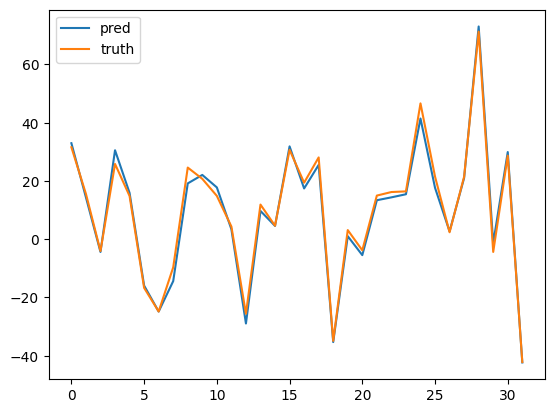

In [ ]:
# Predictions from training, part 2
plt.plot(range(n), predictions[-1][0, :, 2].detach(), label='pred')
plt.plot(range(n), truths[-1][0, :, 2], label='truth')
# plt.xlim(100, 150)
# plt.ylim(-1, 1)
plt.legend()

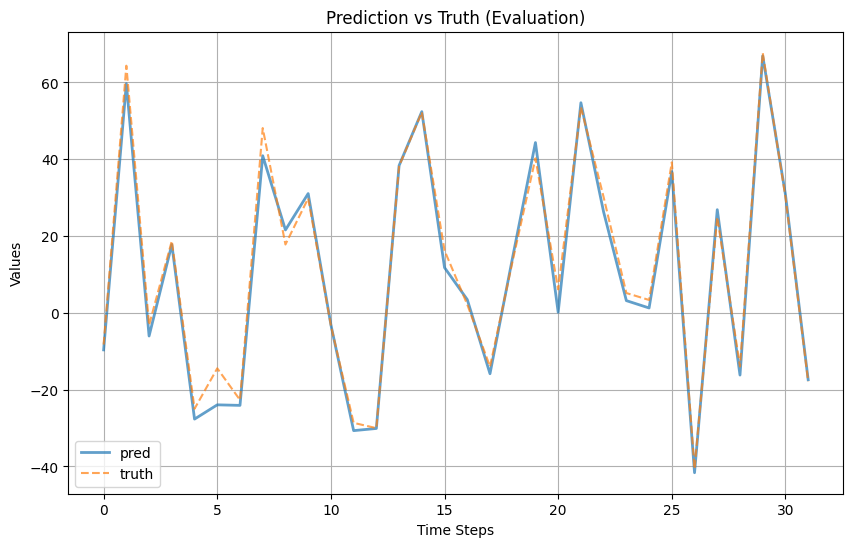

In [ ]:
# Predictions from inference
model.eval()

# Generate new data for testing
test_inputs = torch.randn(bsz * sl, d_in).to(device)
test_targets = lds.reset().generate_trajectory(test_inputs)
test_inputs = test_inputs.reshape(bsz, sl, d_in)
test_targets = test_targets.reshape(bsz, sl, d_out)

if NEXT_STEP_PREDICTION:
    test_inputs = test_targets[:, :-1]
    test_targets = test_targets[:, 1:]

with torch.no_grad():
    test_predictions, _ = model(test_inputs, test_targets)

plt.figure(figsize=(10, 6))
n = sl - 1 if NEXT_STEP_PREDICTION else sl
plt.plot(range(n), test_predictions[0, :, 2].cpu(), label='pred', alpha=0.7, linewidth=2)
plt.plot(range(n), test_targets[0, :, 2].cpu(), label='truth', alpha=0.7, linestyle='dashed')
plt.grid(True)
plt.legend()
plt.title('Prediction vs Truth (Evaluation)')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()